# What Makes A Best Original Screenplay?

    By Allison Ragan and Allison Shafer
    American University
    STAT-696 Applied Natural Language Processing

# Objective

# Table of Contents

    I. Package Imports
    II. Extract Text
    III. Data Cleaning
        i. AR
        ii. AS
        iii. Concatenate AR + AS
    IV. NLP Transformations
        i. CountVectorized
        ii. TFIDF
    V. Sentiment Analysis
        i. Sentiment Analysis -- Dialogue
        ii. Sentiment Analysis -- Full Script
    VI. Topic Modeling
        i. Topic Modeling -- Dialogue
        ii. Topic Modeling -- Full Script
    VII. K-Means Clustering
        i. K-Means Clustering -- Dialogue
        ii. K-Means Clustering -- Full Script
    VIII. Results
    IX. Deprecated Code

## Package Imports

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import re
import nltk
from nltk import word_tokenize as w_tokenize
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
from nltk.corpus import stopwords
import string
punc = string.punctuation
stop_words = set(stopwords.words('english') + ["..."])
from afinn import Afinn
#!pip install afinn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pdfminer
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.high_level import extract_text
import PyPDF2
# !pip install PyPDF2

## Extract Text

In [2]:
## AS
# extract text from list of pdf titles and create dataframe of text
path = './Scripts/'
end = '.pdf'
titles = ['1917', '20th_Century_Women', 'BridgeofSpies', 'ExMachina', 'First_Reformed',
         'Get_Out', 'GreenBook', 'Hell_or_HighWater', 'InsideOut', 'KnivesOut', 'LadyBird',
         'LaLaLand', 'Manchester_By_TheSea', 'MarriageStory', 'Parasite', 'Roma', 
          'ShapeofWater', 'Spotlight', 'StraightOuttaCompton', 'TheBigSick', 
         'TheFavourite', 'TheLobster', 'ThreeBillboards', 'Vice']

movie_scripts = []
for title in titles:
    script = extract_text(path + title + end)
    movie_scripts.append(script)
    print (title)

# create dataframe of scripts/titles from lists    
movie_df = pd.DataFrame(list(zip(titles, movie_scripts)), columns = ['Title', 'Script'])

1917
20th_Century_Women
BridgeofSpies
ExMachina
First_Reformed
Get_Out
GreenBook
Hell_or_HighWater
InsideOut
KnivesOut
LadyBird
LaLaLand
Manchester_By_TheSea
MarriageStory
Parasite
Roma
ShapeofWater
Spotlight
StraightOuttaCompton
TheBigSick
TheFavourite
TheLobster
ThreeBillboards
Vice


In [3]:
## AR
# add label for original screenplay win, best picture win, and year
orig_screen_win = [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
best_pic_win = ['Nom', None, 'Nom', None, None, 'Nom', 'Win', 'Nom', None, None, 'Nom', 'Nom', 'Nom', 'Nom', 'Win', 'Nom', 'Win', 'Win', None, None, 'Nom', None, 'Nom', 'Nom']
year = [2019, 2016, 2015, 2015, 2018, 2017, 2018, 2016, 2015, 2019, 2017, 2016, 2016, 2019, 2019, 2018, 2017, 2015, 2015, 2017, 2018, 2016, 2017, 2018]
reviewer = ["Shafer", "Shafer", "Shafer", "Shafer", "Ragan", "Shafer", "Ragan", "Ragan", "Shafer", "Shafer", "Ragan", "Ragan", "Shafer", "Ragan", "Shafer", "Ragan", "Ragan", "Shafer", "Shafer", "Ragan", "Ragan", "Shafer", "Ragan", "Ragan"]

# sanity check -- should return True
print(f"\n\nSanity check for lists: {len(orig_screen_win) == len(year) == len(best_pic_win) ==  len(list(movie_df['Title'])) == len(reviewer)}")

movie_df['year'] = year
movie_df['orig_screen_win'] = orig_screen_win
movie_df['best_pic_win'] = best_pic_win
movie_df['reviewer'] = reviewer



Sanity check for lists: True


## Data Cleaning

### AR

In [4]:
ar = movie_df[movie_df['reviewer'] == "Ragan"].copy()
raw_scripts = list(ar['Script'])

In [5]:
def drop_start(idx, todrop):
    return raw_scripts[idx].replace(todrop, "")

extraneous = ["Scripts.com\n\nFirst Reformed\n\nBy Paul Schrader\n\nPage 1/57\n\n\x0c", 
              "GREEN BOOK \n\nWritten by \n\nNick Vallelonga & Brian Currie & Peter Farrelly \n\n\x0c", 
              "Scripts.com\n\nHell or High Water\n\nBy Taylor Sheridan\n\nPage 1/42\n\n\x0c", 
              " \n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n\n \n \n \n \n \n \n \n \n \n \n \n\nLADY BIRD \n\nwritten by \n\nGreta Gerwig \n\n\x0c \n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n\nii. \n\n", 
              "LA LA LAND\n\nby\n\nDamien Chazelle\n\n\x0c", 
              "MARRIAGE STORY\n\nWritten and Directed by Noah Baumbach\n\n\x0cBlack.\n\n", 
              "IN ENGLISH\n\n\x0cROMA\n\nWritten and Directed by\n\nAlfonso Cuarón\n\nDates in RED are meant only as a tool for the different departments for \nthe specific historical accuracy of the scenes and are not intended to \nappear on screen. \n\n\x0cThursday, September 3rd, 1970\n\n", 
              "F O R   Y O U R   C O N S I D E R A T I O N\n\nB E S T   O R I G I N A L   S C R E E N P L A Y\n\nG U I L L E R M O   D E L   T O R O\n&\nV A N E S S A   T A Y L O R\n\n\x0c1                             \n\n1\n\n", 
              "THE BIG SICK\n\nby\nEmily V. Gordon & Kumail Nanjiani\n\n\x0c1\n\n", 
              "F O R   Y O U R   C O N S I D E R A T I O N\n\nW R I T T E N   B Y\n\nD E B O R A H   D A V I S   A N D   T O N Y   M C N A M A R A\n\n\x0cW R I T T E N   B Y\n\nD E B O R A H   D A V I S   A N D   T O N Y   M C N A M A R A\n\n\x0cTHE FAVOURITE\n\nWritten by\n\nDeborah Davis and Tony McNamara\n\nFINAL SHOOTING SCRIPT - 23rd MARCH 2017\n\nElement Pictures\n21 Mespil Road \nDublin 4\nIreland\n\nScarlet Films\n3 Oakley Studios\nUpper Cheyne Row\nLondon SW3 5JW, UK\n\n \n\n\x0c1\n\n2\n\n3\n\n4\n\n5\n\n6\n\n", 
              "F O R   Y O U R   C O N S I D E R A T I O N\n\nB E S T   O R I G I N A L   S C R E E N P L A Y\n\nM A R T I N   M c D O N A G H\n\n\x0cTHREE BILLBOARDS OUTSIDE EBBING, MISSOURI\n\nYou Red Welby?\n\nby\nMartin McDonagh\n\n1\n\n", 
              "Written and Directed by\n\nVICE\n\nAdam McKay\n\n\x0c"]

for r in range(len(raw_scripts)):
    raw_scripts[r] = drop_start(r, extraneous[r])

In [6]:
def expand_contractions(text):
    text = re.sub("\'s", " is", text) # it's --> it is
    text = re.sub("ain\'t", "are not", text) # ain't --> are not
    text = re.sub("n\'t", " not", text) # don't --> do not
    text = re.sub("\'re", " are", text) # you're --> you are
    text = re.sub("\'d", " would", text) # she'd --> she would
    text = re.sub("\'ll", " will", text) # he'll --> he will
    text = re.sub("\'ve", " have", text) # we've --> we have
    text = re.sub("\'m", " am", text) # I'm --> I am
    return text

for i in range(len(raw_scripts)):
    raw_scripts[i] = expand_contractions(raw_scripts[i])

In [7]:
def clean_lists(lis):
    cust_punct = string.punctuation + "`" + "'" + "’" + "”" + "“" + "..."
    if type(lis) != list:
        lis = w_tokenize(lis)
    lis = [l.replace("'", "") for l in lis]
    # strip punctuation
    lis = [t.lower() for t in lis if t not in set(cust_punct)]
    # lemmatize + lowercase
    lis = [lemma.lemmatize(l) for l in lis]
    # drop stop words
    lis = [t for t in lis if t not in set(stop_words)]
    # strip new lines
    lis = [re.sub('\s+', ' ', l) for l in lis]
    # remove all non-alphanumeric -- fail safe code
    lis = [re.sub("[^0-9a-zA-Z]+", "", l) for l in lis]
    return lis

In [8]:
def split_dialogue_everything(script, pages):
    first_ref = False
    hhw = False
    other = False

    if script == raw_scripts[0]:
        first_ref = True
        print("First Reformed")
    elif script == raw_scripts[2]:
        hhw = True
        print("Hell or High Water")
    else:
        other = True
        print("Other")
    script = script.replace("'", "")
    # remove page numbers
    script = re.sub(pages, " ", script)
    # remove voiceover --(V.O.)--from script
    script = script.replace("(V.O.)", "")
    # extract dialogue -- some require customization
    # First Reformed
    if first_ref:
        split_script = w_tokenize(script)
        orig_split_script = split_script.copy()
        # find indexes with (
        open_pars = [i for i, e in enumerate(split_script) if e == "("]
        # find indexes with )
        end_pars = [i for i, e in enumerate(split_script) if e == ")"]
        # return words between ( and ) to extract visual cues
        visual_cues_fr = [" ".join(split_script[open_pars[o]+1:end_pars[o]]) for o in range(len(open_pars))]
        # drop visual cues from list
        for o in range(len(open_pars)):
            del split_script[open_pars[o]:end_pars[0]+1]
        # re-join : with character names and drop extra :
        # find indices with :
        char_idx = [i for i, item in enumerate(split_script) if item.endswith(':')]
        # for every index with :, go to the index before and add : to re-join CHARACTER with :
        for b in char_idx:
            split_script[b-1] = split_script[b-1] + split_script[b]
        # drop extraneous colons
        if ":" in split_script:
            split_script.remove(":")
        # append non-character names to dialogue list
        dialogue = [split_script[t] for t in range(len(split_script)) if split_script[t].endswith(":") == False]
        script = orig_split_script
    # Hell or High Water -- script is literally just dialogue
    elif hhw:
        dialogue = script
    # All others
    else:
        # split on combo of caps and new lines
        split_script = re.split("\\n[A-Z]*\s?\\n", script)
        visual_cues = []
        # if begins with INT or EXT then it's a setting and the next line is visual cue
        settings = [v for v in range(len(split_script)) if split_script[v].startswith("INT")
                    or split_script[v].startswith("EXT")
                    or split_script[v].startswith("VISUALS|VISUAL")]
        # extract visual cues
        visual_cue = [split_script[s+1] for s in settings]
        # remove word if uppercase
        visual_cue = [w for w in visual_cue if w.isupper() == False]
        visual_cues.append(visual_cue)
        sets_cues_id = []
        for s in settings:
            sets_cues_id.append(s)
            sets_cues_id.append(s+1)
        # remove settings and visual cues from dialogue
        dialogue_ms = [split_script[d] for d in range(len(split_script)) if d not in sets_cues_id]
        # removing entries that are just all caps (i.e. CHARLIE)
        dialogue_wo_upper = [d for d in dialogue_ms if d.isupper() == False]
        # removing entries that don't have a character indicator
        dialogue_wo_indicator = [t for t in dialogue_wo_upper if t[:3].isupper() == False]
        # split out indicators from dialogue + flatten nested list
        dialogue_split = [re.split("[A-Z]\s?\\n", t) for t in dialogue_wo_upper if t[:3].isupper()]
        # drop indicator + flatten split list
        dialogue_flatten = []
        for ts in dialogue_split:
            ts.pop(0)
            dialogue_flatten.append(ts)
        dialogue_flatten = [item for sublist in dialogue_flatten for item in sublist]
        dialogue = dialogue_flatten + dialogue_wo_indicator
        dialogue = w_tokenize(" ".join(dialogue))
    # clean + join lists
    everything_list = " ".join(clean_lists(script))
    dialogue_list = " ".join(clean_lists(dialogue))
    # return everything list and dialogue list
    return everything_list, dialogue_list

In [9]:
# regex codes for page numbers
page = ["\\nPage \d+/57",
       "\\x0c                                   \\n\\n   \d+\.",
       "\\nPage \d+/42",
       "\\x0c\s?[\\n\\n ?\\n ?]+\d+\. ?\\n",
       "Revision\\n\\n\d+\.\\n",
       "\\x0c                                                 \d+\.\\n",
       "\\x0c\d+\.\\n",
       "\\x0c\d+                             \\n\\n\d+",
       "\\n\\x0c\d+\\n",
       "\\x0cTHE FAVOURITE SHOOTING SCRIPT 6 MAR 17   \d+.\\n",
       "\\n\d+\.",
       "\\x0c\d+\.\\n"]

In [10]:
# custom pre-processing code
# La La Land 
raw_scripts[4] = re.sub("\\n\d+\\n", "", raw_scripts[4])
raw_scripts[4] = re.sub("\\n[A-Z]\d+\\n", "", raw_scripts[4])
raw_scripts[4] = re.sub("\[(.*?)\]", "", raw_scripts[4])

# Shape of Water 
raw_scripts[7] = raw_scripts[7].replace("\n\nTHE SHAPE OF WATER\nTHE SHAPE OF WATER\nWritten by\n\nGuillermo del Toro\nWritten by\n&\nVanessa Taylor\nGuillermo del Toro\n&\nVanessa Taylor\nStory by\nGuillermo del Toro\n\nStory by\nGuillermo del Toro\n\nFOX SEARCHLIGHT PICTURES, INC. \n10201 W. Pico Blvd.\nLos Angeles, CA 90035\n\nFOX SEARCHLIGHT PICTURES, INC. \n10201 W. Pico Blvd.\nLos Angeles, CA 90035\n\nALL RIGHTS RESERVED. COPYRIGHT ©2016 WILLOW AND OAK, INC. NO PORTION OF THIS SCRIPT MAY BE \nPERFORMED, PUBLISHED, REPRODUCED, SOLD OR DISTRIBUTED BY ANY MEANS, OR QUOTED OR PUBLISHED IN ANY \nMEDIUM, INCLUDING ANY WEB SITE, WITHOUT THE PRIOR WRITTEN CONSENT OF WILLOW AND OAK, INC. DISPOSAL \nOF THIS SCRIPT COPY DOES NOT ALTER ANY OF THE RESTRICTIONS SET FORTH ABOVE.\n\nALL RIGHTS RESERVED. COPYRIGHT ©2016 WILLOW AND OAK, INC. NO PORTION OF THIS SCRIPT MAY BE \nPERFORMED, PUBLISHED, REPRODUCED, SOLD OR DISTRIBUTED BY ANY MEANS, OR QUOTED OR PUBLISHED IN ANY \nMEDIUM, INCLUDING ANY WEB SITE, WITHOUT THE PRIOR WRITTEN CONSENT OF WILLOW AND OAK, INC. DISPOSAL \nOF THIS SCRIPT COPY DOES NOT ALTER ANY OF THE RESTRICTIONS SET FORTH ABOVE.", "")
raw_scripts[7] = re.sub("\\n\d+\\n", "", raw_scripts[7])
raw_scripts[7] = re.sub("\\n[A-Z]\d+\\n", "", raw_scripts[7])

# The Favourite 
raw_scripts[9] = re.sub("\\n\d+\\n", "", raw_scripts[9])

# Three Billboards 
raw_scripts[10] = re.sub("\\n\d+\\n", "", raw_scripts[10])

In [11]:
# loop over all scripts and apply function to split dialogue from everything + clean
# instantiate empty lists to become columns
master_dialogue = []
master_cleaned_everything = []
for r in range(len(raw_scripts)):
    # apply function to every script
    everything, dialogue = split_dialogue_everything(raw_scripts[r], page[r])
    # add to master lists
    master_cleaned_everything.append(everything)
    master_dialogue.append(dialogue)

# sanity check
len(master_dialogue) == len(master_cleaned_everything)

First Reformed
Other
Hell or High Water
Other
Other
Other
Other
Other
Other
Other
Other
Other


True

In [12]:
# return processed scripts to data frame
# sanity checks -- Expect 3 returns of True
len(master_dialogue) == 12
len(master_cleaned_everything) == 12
len(master_dialogue) == len(master_cleaned_everything)

# make column of dialogue
ar['cleaned_dialogue'] = master_dialogue

# make everything column
ar['cleaned_script'] = master_cleaned_everything

### AS

In [13]:
ACS = movie_df[movie_df['reviewer'] == 'Shafer'].copy()

In [14]:
# Create function to remove extraneous information from title pages, etc.

ext_list = ['1917\n\nWritten by\n\nSam Mendes\n&\nKrysty Wilson-Cairns\n\n© 2018 Storyworks Productions Limited. All rights reserved.\n\n\x0cii\nii\n\n‘Life, to be sure,\n Is nothing much to lose,\n But young men think it is,\n And we were young.’\n\n-A.E. Housman\n\n‘We have so much to say, and we shall never say it.’\n\n-Erich Maria Remarque\nAll Quiet On The Western Front \n\n\x0ciii\niii\n\nThe following script takes place in real time, and - with the \nexception of one moment - is written and designed to be one single \ncontinuous shot. \n\nNOTE:\n\n\x0c                                                                1.\n',
             '20th Century Women\n\nby\n\nMike Mills\n\n\x0cEXT.',
             'Scripts.com\n\nBridge of Spies\n\nBy Matt Charman\n\nPage 1/124\n\n\x0cTITLE OVER BLACK: 1957.',
             ' \n\nEX MACHINA\n\nBy','\n\nAlex Garland\n\n','Alex Garland 2013\nc/o DNA Films Ltd.',
            '10 Amwell Street\nLondon EC1R 1UQ\nT:','\n\+44 (0)207 843 4410\n\n\x0c','\n\n\x0c'
             'Scripts.com\n\nGet Out\n\nBy Jordan Peele\n\nPage 1/94\n\n\x0c',
             'INSIDE OUT\n\noriginal story by\n\nPete Docter\nRonnie Del Carmen\n \n\nScreenplay by\n\nPete Docter\nMeg LeFauve\nJosh Cooley\n\n\x0cBLACK.',
             'KNIVES OUT\n\nA Murder Mystery by\n\nRian Johnson\n\nSCREEN SCRIPT\n\n\x0cEXT.',
             'MANCHESTER BY THE SEA\n\nWritten & Directed \n\nby\n\nKenneth Lonergan\n\n\x0cEXT.',
             'F O R   Y O U R   C O N S I D E R A T I O N\n\nOUTSTANDING ORIGINAL SCREENPLAY \nSCREENPLAY BY\nBONG JOON HO AND HAN JIN WON\nSTORY BY\nBONG JOON HO\n\n\x0c \n \n \n \n \n \n \n \n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n\n \n \nPARASITE\n \n \n \n\nScreenplay by\n\n \nStory by\n\nBong Joon Ho\n\nBong Joon Ho and Han Jin Won\n\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n\n \n \n \n \n \n \n \n \n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n\n\x0c1\n\n2\n\nTITLE SEQUENCE OVER',
             'Scripts.com\n\nSpotlight\n\nBy Tom McCarthy\n\nPage 1/152\n\n\x0c1',
             'STRAIGHT OUTTA COMPTON\n\nBy\n\nLeigh Savidge and Alan Wenkus\n\nRevised 8/16/08',
            '\nXenon Pictures','\n(310)451-5510','\n\n\x0cEXT.',
            'Scripts.com\n\nGet Out\n\nBy Jordan Peele\n\nPage 1/94\n\n\x0c',
            'NEONratedAwards.com\n\n ',
            'THE LOBSTER\n\nWritten by',
            '\n\nYorgos Lanthimos', 
            '& Efthimis Filippou\n\n30 April 2013',
            '\n\nElement Pictures\nLimp\nScarlet', 
            'Films\n\n 1',
             'Scripts.com\n\nThe Lobster\n\nBy Yorgos Lanthimos\n\nPage 1/39\n\n\x0c',
            ' BLACK \nAccompanied by dark but curiously upbeat MUSIC. \nAt the end of the credits, the MAIN TITLE, in strange \ncalligraphy, fills the screen -- \n\n“PARASITE”\n\n1\n \nMUSIC FADES. ',
           'THE END.\n\nFOR LANCE CORPORAL ALFRED H. MENDESST BATTALION, KING’S ROYAL RIFLE CORPS\n\nWHO TOLD US THE STORIES\n\n\x0c"']

def drop_start(text, ext_list):
    new_text = text
    for match in ext_list:
        new_text = re.sub(match, '', new_text)
    return new_text

In [15]:
# apply function to do initial light clean on columns and make new fields

ACS['FirstClean'] = ACS['Script'].apply(drop_start, args = (ext_list, ))
ACS

,Title,Script,year,orig_screen_win,best_pic_win,reviewer,FirstClean
0,1917,1917\n\nWritten by\n\nSam Mendes\n&\nKrysty Wi...,2019,0,Nom,Shafer,...
1,20th_Century_Women,20th Century Women\n\nby\n\nMike Mills\n\n EXT...,2016,0,None,Shafer,OCEAN - DAY \n\nHigh overhead shot looking do...
2,BridgeofSpies,Scripts.com\n\nBridge of Spies\n\nBy Matt Char...,2015,0,Nom,Shafer,\nThe height of the Cold War. The United Stat...
3,ExMachina,\n\nEX MACHINA\n\nBy \n\nAlex Garland\n\n© Al...,2015,0,None,Shafer,© \n +44 (0)207 843 4410\n\n Music starts.\n...
5,Get_Out,Scripts.com\n\nGet Out\n\nBy Jordan Peele\n\nP...,2017,1,Nom,Shafer,"I appeal to you therefore, brothers, by the me..."
8,InsideOut,INSIDE OUT\n\noriginal story by\n\nPete Docter...,2015,0,None,Shafer,\n\nJOY (V.O.)\nDo you ever look at someone an...
9,KnivesOut,KNIVES OUT\n\nA Murder Mystery by\n\nRian John...,2019,0,None,Shafer,THROMBEY ESTATE MANOR HOUSE - DAWN\n\nThe gro...
12,Manchester_By_TheSea,MANCHESTER BY THE SEA\n\nWritten & Directed \n...,2016,1,Nom,Shafer,MANCHESTER HARBOR -- SEA. DAY.\n\nA small com...
14,Parasite,F O R Y O U R C O N S I D E R A T I O N\n\...,2019,1,Win,Shafer,BLACK \n \nAccompanied by dark but curiously...
17,Spotlight,Scripts.com\n\nSpotlight\n\nBy Tom McCarthy\n\...,2015,1,Win,Shafer,"INT. POLICE STATION, BOSTON - NIGHT, 1976 1\n..."


In [16]:
# Create function to clean unneeded pieces from script. ## These used to be all one tool called "multiclean"

def remove_contractions(text):
    text = re.sub(r"n\'t", " not", text) # handle contractions
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'d", " had", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"ain\'t", "are not", text)
    return text

def remove_page_nums(text):
    text = re.sub('\n11/26/14', '', text)
    text = re.sub('\n\n\\x0c\s+\d+\.','', text)
    text = re.sub('\nPage \d+\/\d+', '', text)
    text = re.sub('\n\/Page', '', text)
    text = re.sub('\\x0c|\\x0c ', '', text)
    text = re.sub('\\x0c\d\.', ' ', text)
    text = re.sub('\n+\\x0c\d+','', text)
    text = re.sub('\n\n\\x0c\s+\d+\.|\n\n\\x0c\s+\d+\.|\\x0c','', text)
    return text

def remove_space_digs(text):
    text = re.sub('\n\*\n', '', text)
    text = re.sub("\’", '', text) #remove possesives
    text = re.sub('^\s+','',text)
    text = re.sub('\s+\d\.', '', text)
    text = re.sub('\d\.|\d+\.', '', text)
    text = re.sub('\n\s\d+\.\n|\n*\s+\\n+\d+\.', ' ', text)
    text = re.sub('[“]', '', text)
    text = re.sub('\n\d\.| \d\.|\n \d+\.|\n\d+\.', '', text)
    text = re.sub('\n\d+|\n\d+\.| \d+\n| \d+\.', '', text)
    text = re.sub('\n\*\n', '', text)
    text = re.sub('^\n\(\)- ', '', text)
    text = re.sub('[--]', '', text)
    text = re.sub('[#]', '', text)
    text = re.sub('[©]', '', text)
    text = re.sub('[“]', '', text)
    text = re.sub('^\n\(d+\)d+\-d+ ', '', text)
    text = re.sub('\s+\d', '', text)
    text = re.sub('\(\d+\)', '', text)
    text = re.sub('\d+\n+\d+\w\n+\d|\n+\d+', '', text)
    text = re.sub('\n\d+\.', '', text)
    text = re.sub('\d', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('\n\d\.| \d\.|\n \d+\.|\n\d+\.| \d\n|\n\d|\n\d |\n\d\n', '', text)
    return text

def remove_words(text):
    text = re.sub('TITLES:', '', text)
    text = re.sub('\(V\.O\.\)|\(O\.S\.\)|\(O\.C\.\)| V.O.|O\.S\.|V\.O\.|\sV\.O\.', '', text)
    text = re.sub('^Films\n+ \d\n\n', '', text)
    text = re.sub("\(CONTINUED:\)|\(CONTINUED\)|CONTINUED:|COUNTINUOUS| CONTINUOUS|CONT'D|\(CONT'D\)", ' ', text)
    text = re.sub("\(CONT\’D\)| \(CONT\'D\)\s+|\(CONT\'D\)|\(CONT\'D\)|\s\(CONT\'D\)\s+| (CONT\’D)",'',text)
    text = re.sub("\(CONTINUED:\)|\s\(CONT\’D\)\n| \(CONT\’D\) \n|\(CONTINUED\)|CONTINUED:|COUNTINUOUS| CONTINUOUS|CONT'D|\(CONT'D\)| \(CONT'D\)|\(CONT..\d\;D\)", ' ', text)
    text = re.sub(r'14 FINAL SHOOTING SCRIPT  |FINAL SHOOTING SCRIPT|\n 12.17.14 FINAL SHOOTING SCRIPT \d+\.|\n 12.17.14 FINAL SHOOTING SCRIPT |\n+ \d+ FINAL SHOOTING SCRIPT  \n+', '', text)
    text = re.sub("\(CONT’D\)| \(CONT'D\)",'', text)
    text = re.sub("\(CONT’D\)| \(CONT'D\)| \(CONT\\'D\)",' ', text)
    text = re.sub('\(MORE\)', '', text)
    return text
    

In [17]:
# Apply cleaning functions to initially cleaned col (FirstClean)

ACS['SecondClean'] = ACS['FirstClean'].apply(remove_contractions) # does not seem to be working
ACS['SecondClean'] = ACS['SecondClean'].apply(remove_page_nums)
ACS['SecondClean'] = ACS['SecondClean'].apply(remove_space_digs)
ACS['SecondClean'] = ACS['SecondClean'].apply(remove_words)

In [18]:
# Make a combined Visual Cues and Speaking Clean column

stop_words = set(stopwords.words('english'))
punc = string.punctuation


def normalize(text):
    text = text.lower() #lowercase all text
    text = re.sub('\n', ' ', text) # remove newlines
    text = re.sub('[{):?+,<>.!?/(;}]', '', text) # remove punctuation
    text = re.sub('\[\]', '', text)
    text = re.sub("\’", '', text)
    text = re.sub('[“]', '', text) # remove various formats of quoatation marks
    text = re.sub('[”]', '', text)
    text = re.sub("\-", ' ', text)
    text = re.sub("[‘]", ' ', text)
    text = re.sub('\*', '', text)
    text = re.sub('[#]', '', text)
    text = re.sub('[©]', '', text)
    text = re.sub('\s+', ' ', text) # remove multiple spaces
    text = re.sub(r"n\'t", " not", text) # expand contractions
    text = re.sub(r"\'s", " is", text)
    text = re.sub("\'m", " am", text)
    text = re.sub(r"\'d", " had", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"ain\'t", "are not", text) 
    text = w_tokenize(text) # tokenize text
    text = [lemma.lemmatize(w) for w in text] # lemmatize text
    text = [w for w in text if w not in stop_words] # remove stop words
    return text

In [19]:
# Create column of cleaned/normalized visual cues and speaking parts combined. 

ACS['Everything_Clean'] = ACS['SecondClean'].apply(normalize)

In [20]:
# Create function to idenitfy speaking vs. visual cues; returns as what is considered as "dialogue"
## Allie's function
## used to as initial separator of visual cues from speaking parts.

def speaking_parts(text):
    # split on combo of caps and new lines
    split_text = re.split("\\n[A-Z]*\s?\\n", text)

    visual_cues = []
    # if begins with INT or EXT then it's a setting and the next line is visual cue
    settings = [v for v in range(len(split_text)) if split_text[v].startswith("INT")
                or split_text[v].startswith("EXT")]

    # extract visual cues
    visual_cue = [split_text[s + 1] for s in settings]

    # remove word if uppercase
    visual_cue = [w for w in visual_cue if w.isupper() == False]

    visual_cues.append(visual_cue)

    sets_cues_id = []
    for s in settings:
        sets_cues_id.append(s)
        sets_cues_id.append(s + 1)

    # remove settings and visual cues from dialogue
    dialogue = [split_text[d] for d in range(len(split_text)) if d not in sets_cues_id]

    # removing entries that are just all caps (i.e. CHARLIE)
    dialogue = [d for d in dialogue if d.isupper() == False]

    # removing entries that don't have a character indicator
    dialogue_wo_indicator = [t for t in dialogue if t[:3].isupper() == False]
    # split out indicators from dialogue + flatten nested list
    dialogue_split = [re.split("[A-Z]\s?\\n", t) for t in dialogue if t[:3].isupper()]
    # drop indicator + flatten split list
    dialogue_flatten = []
    for ts in dialogue_split:
        ts.pop(0)
        dialogue_flatten.append(ts)
    dialogue_flatten = [item for sublist in dialogue_flatten for item in sublist]
    dialogue = dialogue_flatten + dialogue_wo_indicator
    dialogue = w_tokenize(" ".join(dialogue))

    return dialogue

In [21]:
# Apply function to create Dialogue column for further cleaning separation
# Should result in a list of strings for each script

ACS['Diag_Work'] = ACS['SecondClean'].apply(speaking_parts)

In [22]:
# apply AR cleaning function to standardize all
ACS['cleaned_dialogue'] = ACS['Diag_Work'].apply(lambda x: " ".join(clean_lists(x)))
ACS['cleaned_script'] = ACS['Everything_Clean'].apply(lambda x: " ".join(clean_lists(x)))

# drop extra columns from cleaning
ACS.drop(['FirstClean', 'SecondClean', 'Everything_Clean', 'Diag_Work'], axis = 1, inplace=True)

### Concatenate AR + AS

In [23]:
# sanity check -- expect all True
ar.columns == ACS.columns

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [24]:
movies_df = pd.concat([ar, ACS]).reset_index(drop=True)

In [25]:
# calculate word length
def word_len(script):
    return len(w_tokenize(script))
movies_df['script_length'] = movies_df['cleaned_script'].apply(lambda x: word_len(x))
movies_df['dialogue_length'] = movies_df['cleaned_dialogue'].apply(lambda x: word_len(x))

In [26]:
movies_df = movies_df.assign(
    # add genres
    Genres = ['Drama', 'Drama', 'Drama-Mystery Suspense', 'Comedy-Drama', 
                           'Comedy-Drama', 'Drama', 'Drama', 'Drama-SciFi', 
                           'Comedy-Romance', 'Drama', 'Comedy-Drama', 'Drama',
                           'Drama','Comedy-Drama', 'Drama-Mystery Suspense', 
                           'Drama-Mystery Suspense-SciFi','Horror-Mystery Suspense', 
                           'Animation-Kids and Family', 'Drama-Mystery Suspense', 
                           'Drama', 'Drama', 'Drama-Mystery Suspense', 'Drama', 
                           'Comedy-Drama-SciFi'],
    GenresAlt = ['Drama', 'Drama', 'Drama', 'Comedy-Drama', 
                           'Comedy-Drama', 'Drama', 'Drama', 'Drama', 
                           'Comedy-Romance', 'Drama', 'Comedy-Drama', 'Drama',
                           'Drama','Comedy-Drama', 'Drama', 
                           'SciFi','Horror', 
                           'Animation', 'Mystery', 
                           'Drama', 'Drama', 'Drama', 'Drama', 
                           'Comedy-Drama'],
    GenresBroad = ['Drama', 'Drama', 'Mystery Suspense', 'Comedy-Drama', 
                           'Comedy-Drama', 'Drama', 'Drama', 'Drama', 
                           'Comedy', 'Drama', 'Comedy-Drama', 'Drama',
                           'Drama','Comedy-Drama', 'Mystery Suspense', 
                           'Mystery Suspense','Mystery Suspense', 
                           'Animation', 'Mystery Suspense', 
                           'Drama', 'Drama', 'Mystery Suspense', 'Drama', 
                           'Comedy-Drama'],
    # add rating
    Rating = ['R', 'PG-13','R', 'R', 'PG-13','R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'PG-13', 'R', 
              'R', 'PG', 'PG-13', 'R', 'R', 'R', 'R', 'R'],
    # add critic score
    Critic_Score = [93, 78, 97, 99, 91, 95, 95, 92, 98, 93, 90, 66, 89, 89, 91, 92, 98, 98, 97, 96, 99, 97, 88, 88],
    # add audience score
    Aud_Score = [68, 91, 88, 79, 81, 85, 72, 72, 88, 69, 87, 59, 88, 74, 87, 86, 86, 89, 92, 78, 90, 93, 91, 65],
    # add runtime
    RunTime = [108, 130, 102, 93, 128, 136, 135, 119, 119, 119, 115, 132, 110, 118, 135, 108, 104, 94, 130, 135, 
               132, 129, 147, 118])

## NLP transformations

### CV

In [27]:
# instantiate
bow_all = CountVectorizer(analyzer = 'word', lowercase = True)
# fit + transform training data
bow_all_fit = bow_all.fit_transform(movies_df['cleaned_script'])

In [28]:
# instantiate
bow_dialogue = CountVectorizer(analyzer = 'word', lowercase = True)
# fit + transform
bow_dialogue_fit = bow_dialogue.fit_transform(movies_df['cleaned_dialogue'])

### TFIDF

In [29]:
# instantiate
tfidf_all = TfidfVectorizer(max_features=5000)
# fit + transform training data
tfidf_all_fit = tfidf_all.fit_transform(movies_df['cleaned_script'])
# tfidf_vocab_all = tfidf_dialogue.vocabulary_
# tfidf_vocab_all = {k: v for k, v in sorted(tfidf_vocab_all.items(), key=lambda item: item[1], reverse=True)}
# print(tfidf_vocab_all)

In [30]:
# instantiate
tfidf_dialogue = TfidfVectorizer(max_features=5000)
# fit + transform training data
tfidf_dialogue_fit = tfidf_dialogue.fit_transform(movies_df['cleaned_dialogue'])
# tfidf_vocab_dialogue = tfidf_dialogue.vocabulary_
# tfidf_vocab_dialogue = {k: v for k, v in sorted(tfidf_vocab_dialogue.items(), key=lambda item: item[1], reverse=True)}
# print(tfidf_vocab_dialogue)

viz

- word cloud for winners and losers
- sentiment across genres
- sentiment across winners/losers
- scatterplot of negative score-positive score colored by genre
- scatterplot of negative score-positive score colored by winner/loser
- sentiment distribution for each genre

## Sentiment Analysis -- AR

Using AFINN lexicon, aka the "new ANEW" which calculates a polarity score associated with each word.

### Sentiment Analysis -- Dialogue

In [31]:
# initialize afinn sentiment analyzer
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in list(movies_df['cleaned_dialogue'])]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

afinn_dialogue = pd.DataFrame([list(movies_df['Title']), list(movies_df['Genres']), list(movies_df['GenresBroad']), list(movies_df['orig_screen_win']), sentiment_scores, sentiment_category]).T
afinn_dialogue.columns = ['Titles', 'Genres', 'GenresBroad', 'Winner', 'SentimentScore', 'SentimentCategory']
afinn_dialogue['SentimentScore'] = afinn_dialogue['SentimentScore'].astype('float')

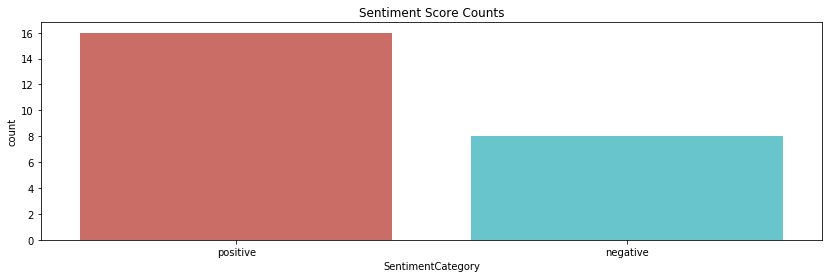

In [32]:
plt.figure(figsize=(14,4))
sns.countplot(x='SentimentCategory', data=afinn_dialogue, palette="hls").set_title("Sentiment Score Counts")
plt.show()

#### Winners vs Losers

In [33]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by=['Winner']).describe()

SentimentScore                                                       \
                count        mean         std     min    25%    50%    75%   
Winner                                                                       
0                19.0   96.578947  490.590043 -1044.0 -150.5  170.0  384.0   
1                 5.0  132.400000  151.640364   -24.0   21.0   89.0  239.0   

               
          max  
Winner         
0       998.0  
1       337.0

Text(0.5, 1.0, 'Boxplot of Sentiment Score by Result')

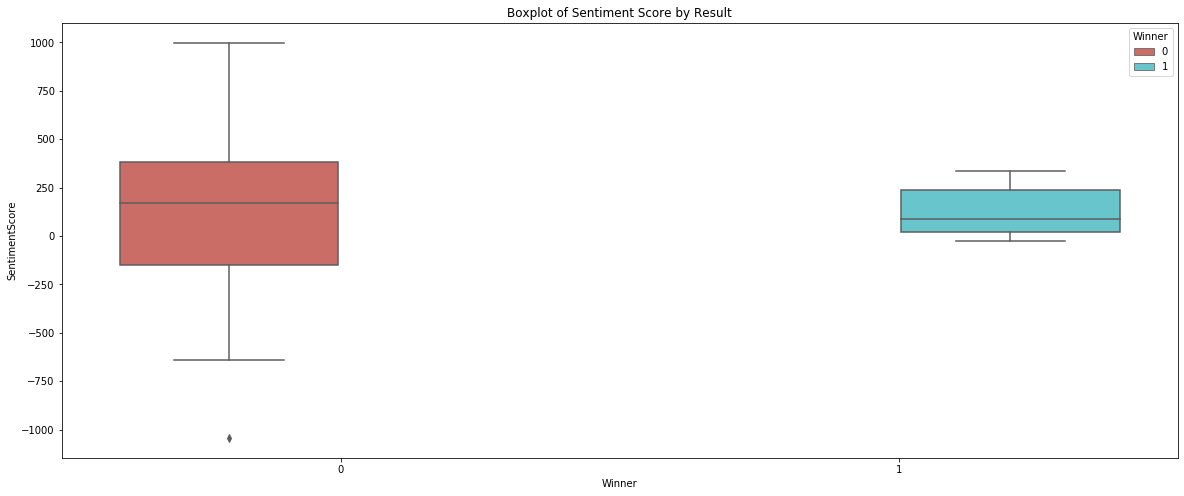

In [34]:
# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='Winner', y="SentimentScore", 
                 hue='Winner', data=afinn_dialogue, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Result')

Text(0.5, 1.0, 'Bar Plot of Sentiment Score by Result')

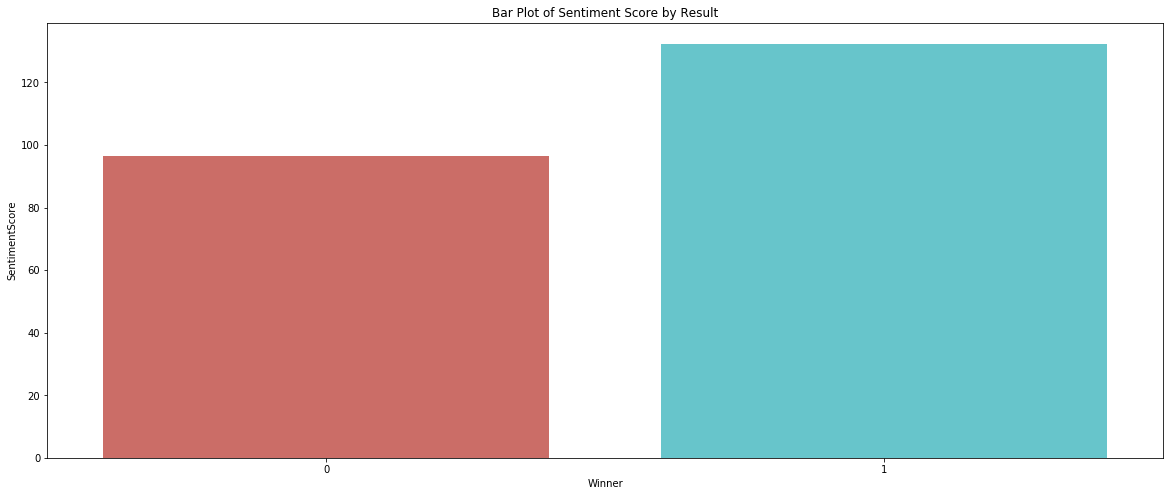

In [35]:
# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Winner", y = "SentimentScore", ax=ax, data=afinn_dialogue, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Result')

Text(0.5, 1.0, 'Count Plot of Sentiment Score by Result')

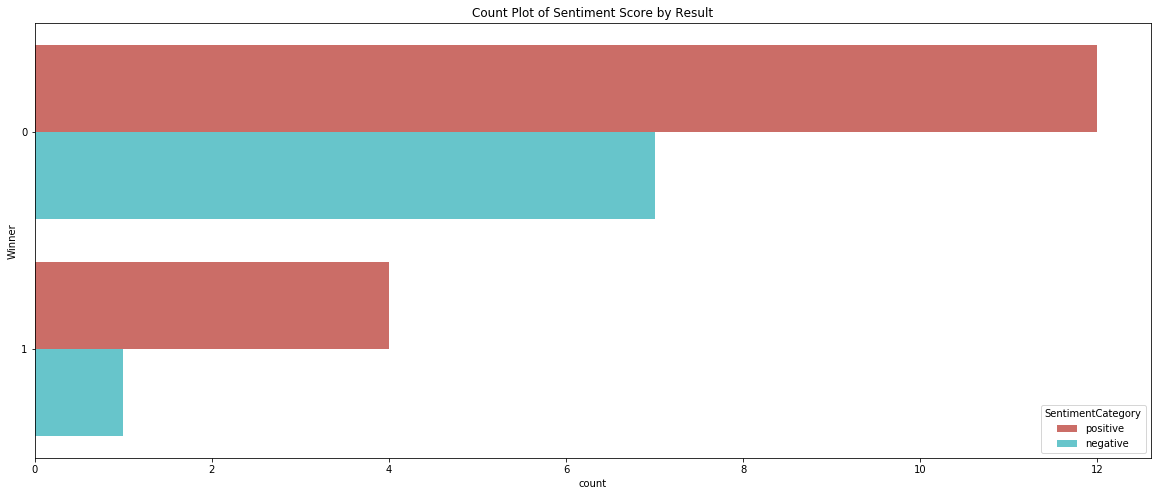

In [36]:
# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="Winner", hue="SentimentCategory", data=afinn_dialogue, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by Result')

#### Genres 

In [37]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by=['Genres']).describe()

SentimentScore                             \
                                      count   mean         std     min   
Genres                                                                   
Animation-Kids and Family               1.0  998.0         NaN   998.0   
Comedy-Drama                            4.0   35.0  735.805681 -1044.0   
Comedy-Drama-SciFi                      1.0  344.0         NaN   344.0   
Comedy-Romance                          1.0  381.0         NaN   381.0   
Drama                                  10.0   62.8  427.855583  -639.0   
Drama-Mystery Suspense                  4.0  -84.0  105.017459  -238.0   
Drama-Mystery Suspense-SciFi            1.0  170.0         NaN   170.0   
Drama-SciFi                             1.0  151.0         NaN   151.0   
Horror-Mystery Suspense                 1.0   21.0         NaN    21.0   

                                                            
                                 25%    50%     75%    max  
Genres                                                      
Animation-Kids and Family     998.00  998.0  998.00  998.0  
Comedy-Drama                 -128.25  330.0  493.25  524.0  
Comedy-Drama-SciFi            344.00  344.0  344.00  344.0  
Comedy-Romance                381.00  381.0  381.00  381.0  
Drama                        -247.00  159.5  312.50  747.0  
Drama-Mystery Suspense       -106.75  -43.5  -20.75  -11.0  
Drama-Mystery Suspense-SciFi  170.00  170.0  170.00  170.0  
Drama-SciFi                   151.00  151.0  151.00  151.0  
Horror-Mystery Suspense        21.00   21.0   21.00   21.0

Text(0.5, 1.0, 'Boxplot of Sentiment Score by Genre')

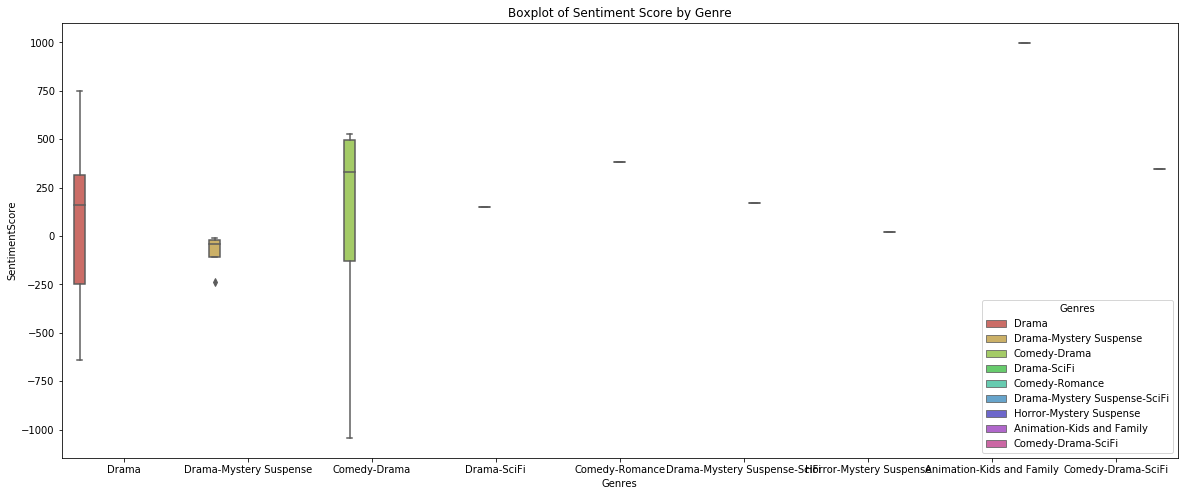

In [38]:
# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='Genres', y="SentimentScore", 
                 hue='Genres', data=afinn_dialogue, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Genre')

Text(0.5, 1.0, 'Bar Plot of Sentiment Score by Genre')

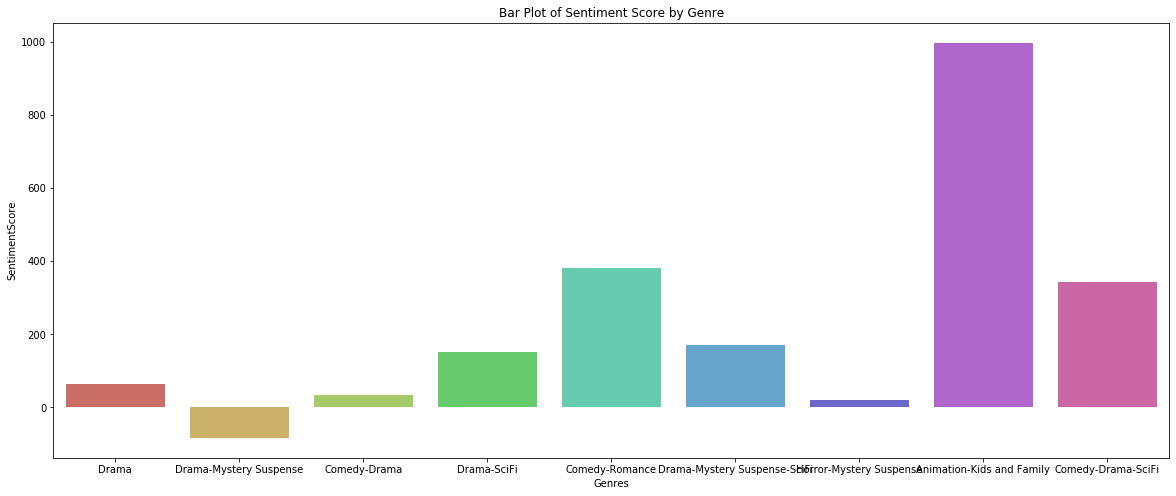

In [39]:
# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Genres", y = "SentimentScore", ax=ax, data=afinn_dialogue, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Genre')

Text(0.5, 1.0, 'Count Plot of Sentiment Score by Genre')

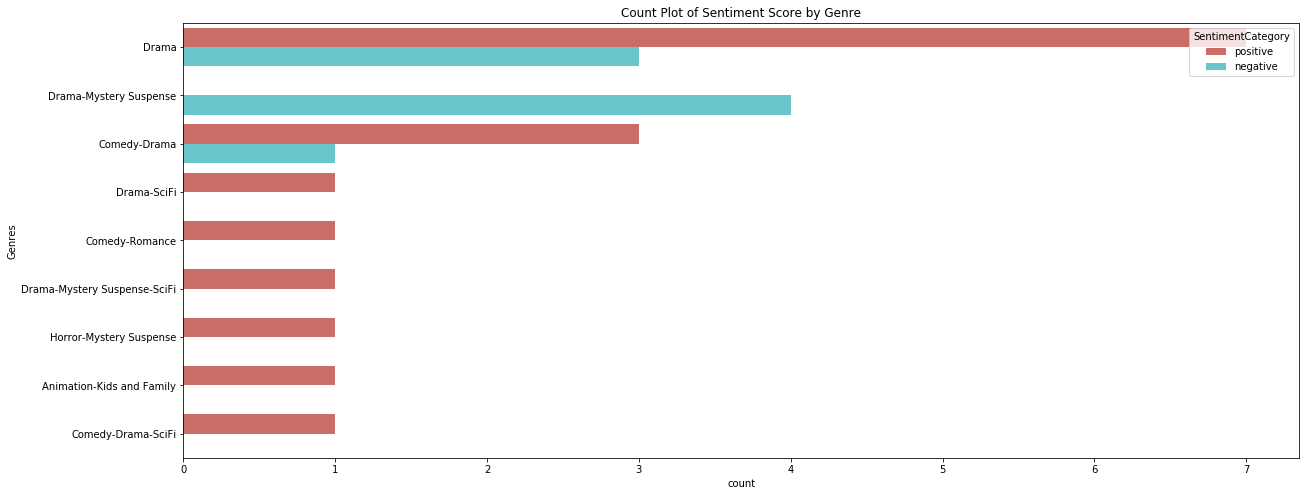

In [40]:
# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="Genres", hue="SentimentCategory", data=afinn_dialogue, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by Genre')

#### Genres (Broad)

In [41]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by=['GenresBroad']).describe()

SentimentScore                                          \
                          count        mean         std     min     25%   
GenresBroad                                                               
Animation                   1.0  998.000000         NaN   998.0  998.00   
Comedy                      1.0  381.000000         NaN   381.0  381.00   
Comedy-Drama                5.0   96.800000  652.038112 -1044.0  177.00   
Drama                      11.0   70.818182  406.769669  -639.0 -148.00   
Mystery Suspense            6.0  -24.166667  132.020327  -238.0  -53.25   

                                       
                    50%    75%    max  
GenresBroad                            
Animation         998.0  998.0  998.0  
Comedy            381.0  381.0  381.0  
Comedy-Drama      344.0  483.0  524.0  
Drama             151.0  288.0  747.0  
Mystery Suspense  -17.5   13.0  170.0

Text(0.5, 1.0, 'Boxplot of Sentiment Score by Genre')

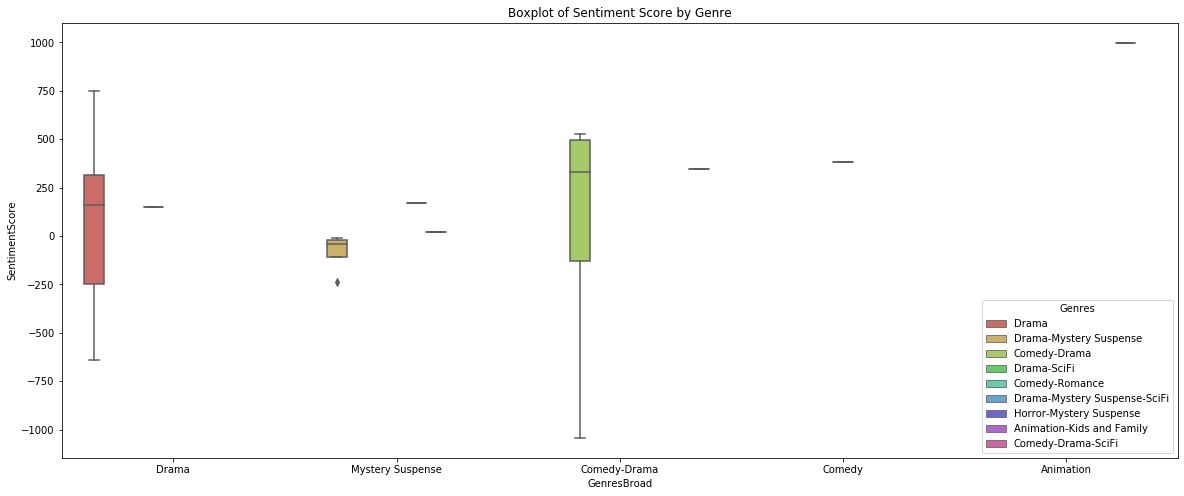

In [42]:
# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='GenresBroad', y="SentimentScore", 
                 hue='Genres', data=afinn_dialogue, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Genre')

Text(0.5, 1.0, 'Bar Plot of Sentiment Score by Genre')

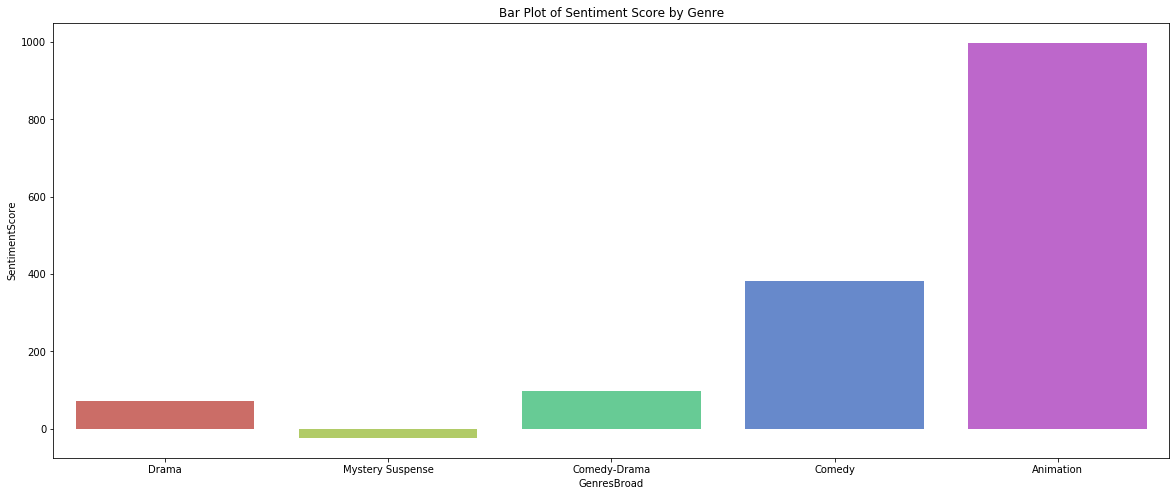

In [43]:
# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "GenresBroad", y = "SentimentScore", ax=ax, data=afinn_dialogue, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Genre')

Text(0.5, 1.0, 'Count Plot of Sentiment Score by GenreBroad')

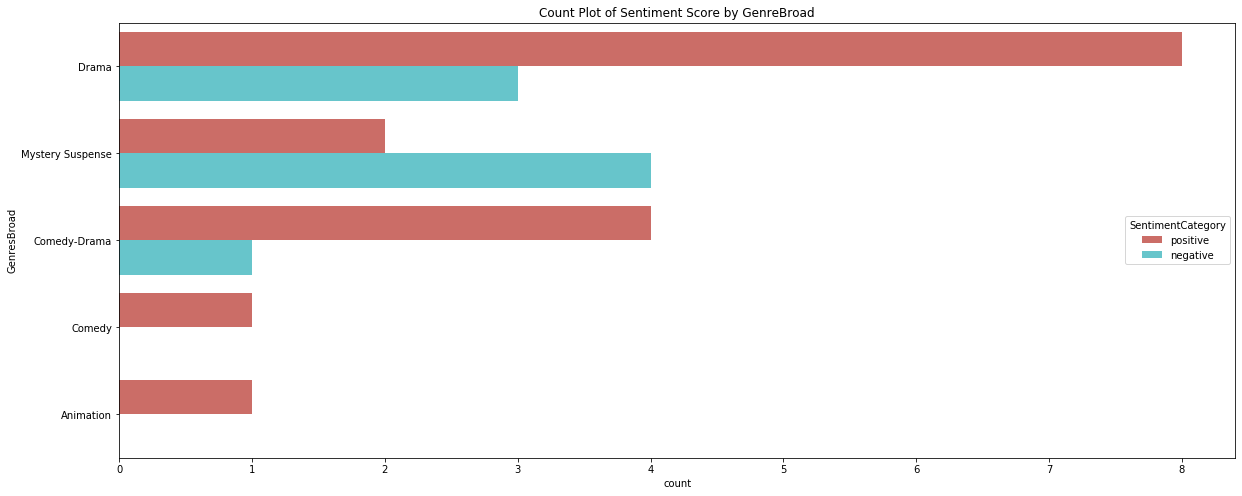

In [44]:
# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="GenresBroad", hue="SentimentCategory", data=afinn_dialogue, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by GenreBroad')

### Sentiment Analysis -- Full Script

In [45]:
# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in list(movies_df['cleaned_script'])]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

afinn_all = pd.DataFrame([list(movies_df['Title']), list(movies_df['Genres']), list(movies_df['GenresBroad']), list(movies_df['orig_screen_win']), sentiment_scores, sentiment_category]).T
afinn_all.columns = ['Titles', 'Genres', 'GenresBroad', 'Winner', 'SentimentScore', 'SentimentCategory']
afinn_all['SentimentScore'] = afinn_all['SentimentScore'].astype('float')

#### Winners vs Losers

In [46]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by=['Winner']).describe()

SentimentScore                                                       \
                count        mean         std     min    25%    50%    75%   
Winner                                                                       
0                19.0   96.578947  490.590043 -1044.0 -150.5  170.0  384.0   
1                 5.0  132.400000  151.640364   -24.0   21.0   89.0  239.0   

               
          max  
Winner         
0       998.0  
1       337.0

Text(0.5, 1.0, 'Boxplot of Sentiment Score by Result')

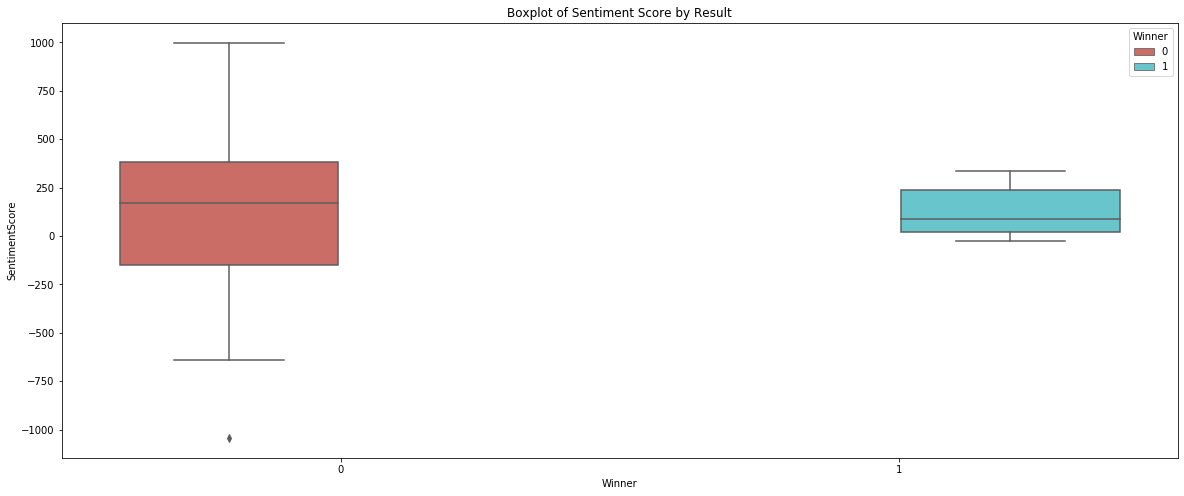

In [47]:
# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='Winner', y="SentimentScore", 
                 hue='Winner', data=afinn_dialogue, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Result')

Text(0.5, 1.0, 'Bar Plot of Sentiment Score by Result')

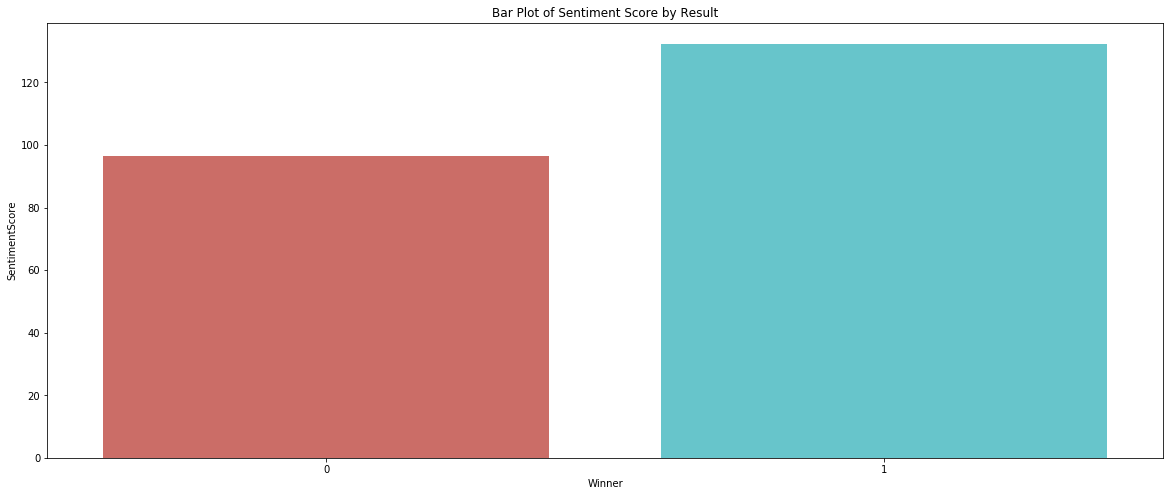

In [48]:
# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Winner", y = "SentimentScore", ax=ax, data=afinn_dialogue, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Result')

Text(0.5, 1.0, 'Count Plot of Sentiment Score by Result')

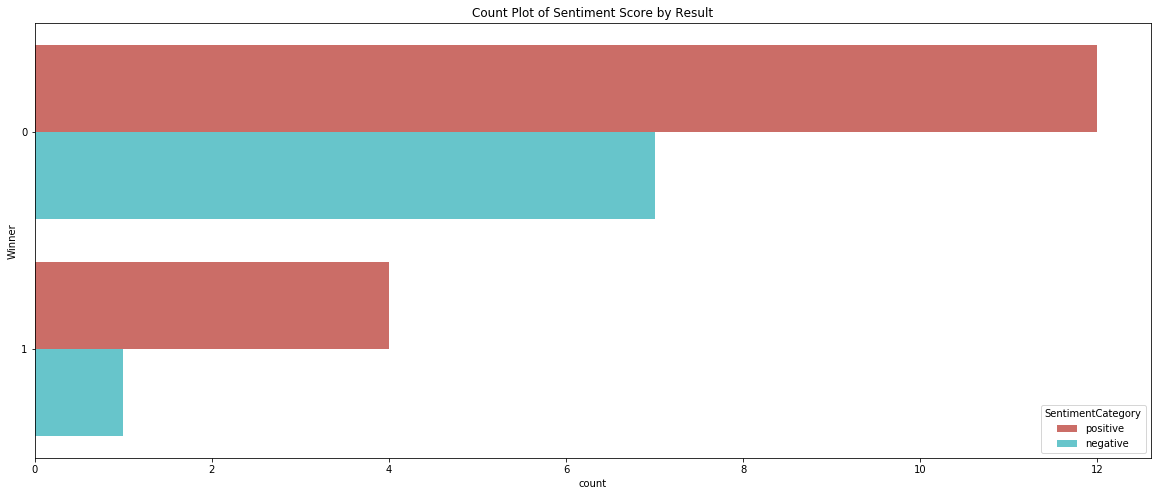

In [49]:
# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="Winner", hue="SentimentCategory", data=afinn_dialogue, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by Result')

#### Genres

In [50]:
# sentiment statistics for winners/losers
afinn_all.groupby(by=['Genres']).describe()

SentimentScore                               \
                                      count     mean         std     min   
Genres                                                                     
Animation-Kids and Family               1.0  1341.00         NaN  1341.0   
Comedy-Drama                            4.0     7.50  771.729443 -1103.0   
Comedy-Drama-SciFi                      1.0   316.00         NaN   316.0   
Comedy-Romance                          1.0   380.00         NaN   380.0   
Drama                                  10.0   -41.20  626.416936 -1358.0   
Drama-Mystery Suspense                  4.0    16.25  233.929298  -238.0   
Drama-Mystery Suspense-SciFi            1.0   158.00         NaN   158.0   
Drama-SciFi                             1.0    92.00         NaN    92.0   
Horror-Mystery Suspense                 1.0   320.00         NaN   320.0   

                                                                
                                  25%     50%      75%     max  
Genres                                                          
Animation-Kids and Family     1341.00  1341.0  1341.00  1341.0  
Comedy-Drama                  -222.50   288.0   518.00   557.0  
Comedy-Drama-SciFi             316.00   316.0   316.00   316.0  
Comedy-Romance                 380.00   380.0   380.00   380.0  
Drama                         -338.50   157.0   314.25   789.0  
Drama-Mystery Suspense        -154.75    43.5   214.50   216.0  
Drama-Mystery Suspense-SciFi   158.00   158.0   158.00   158.0  
Drama-SciFi                     92.00    92.0    92.00    92.0  
Horror-Mystery Suspense        320.00   320.0   320.00   320.0

Text(0.5, 1.0, 'Boxplot of Sentiment Score by Genre')

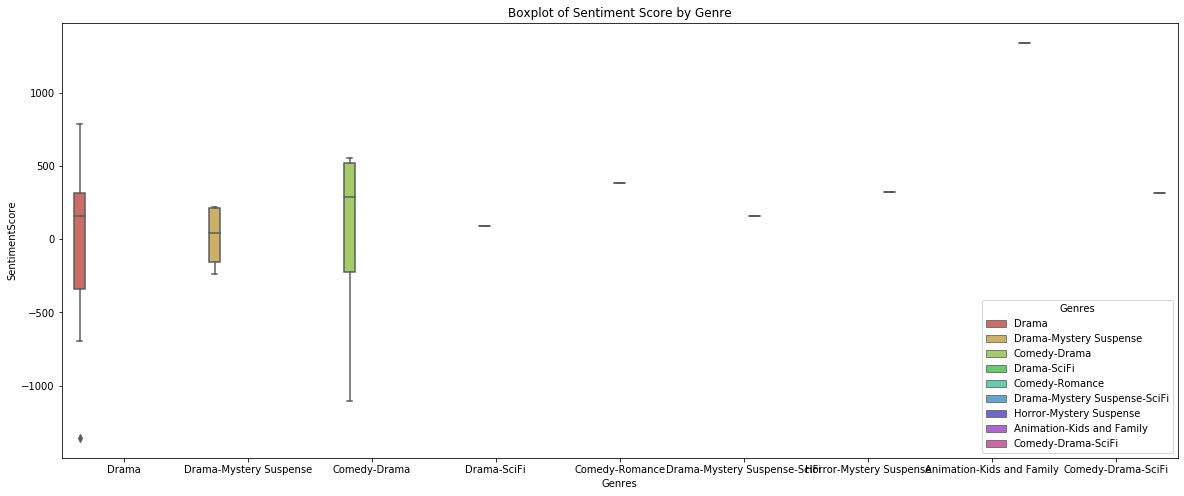

In [51]:
# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='Genres', y="SentimentScore", 
                 hue='Genres', data=afinn_all, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Genre')

Text(0.5, 1.0, 'Bar Plot of Sentiment Score by Genre')

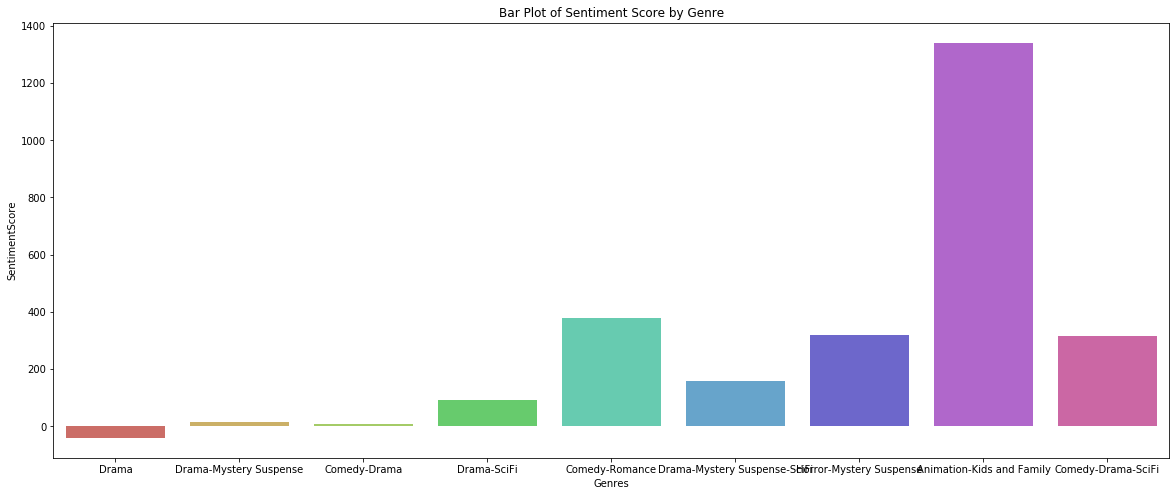

In [52]:
# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Genres", y = "SentimentScore", ax=ax, data=afinn_all, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Genre')

Text(0.5, 1.0, 'Count Plot of Sentiment Score by Genre')

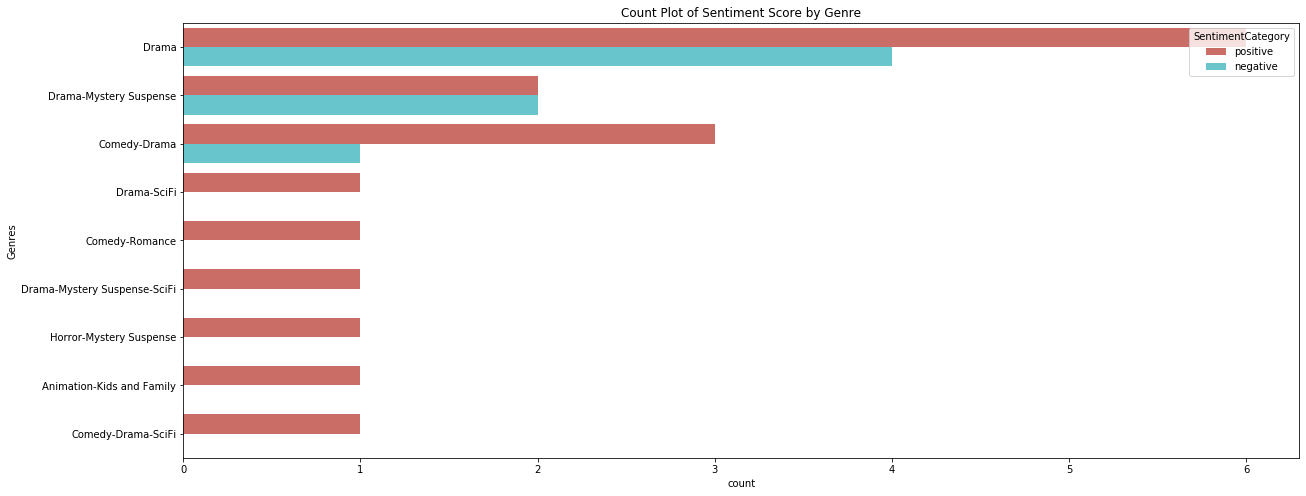

In [53]:
# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="Genres", hue="SentimentCategory", data=afinn_all, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by Genre')

#### Genres (Broad)

In [54]:
# sentiment statistics for winners/losers
afinn_all.groupby(by=['GenresBroad']).describe()

SentimentScore                                            \
                          count         mean         std     min      25%   
GenresBroad                                                                 
Animation                   1.0  1341.000000         NaN  1341.0  1341.00   
Comedy                      1.0   380.000000         NaN   380.0   380.00   
Comedy-Drama                5.0    69.200000  682.428897 -1103.0    71.00   
Drama                      11.0   -29.090909  595.626805 -1358.0  -233.00   
Mystery Suspense            6.0    90.500000  220.656974  -238.0   -55.75   

                                          
                     50%     75%     max  
GenresBroad                               
Animation         1341.0  1341.0  1341.0  
Comedy             380.0   380.0   380.0  
Comedy-Drama       316.0   505.0   557.0  
Drama               92.0   308.5   789.0  
Mystery Suspense   186.0   215.5   320.0

Text(0.5, 1.0, 'Boxplot of Sentiment Score by Genre')

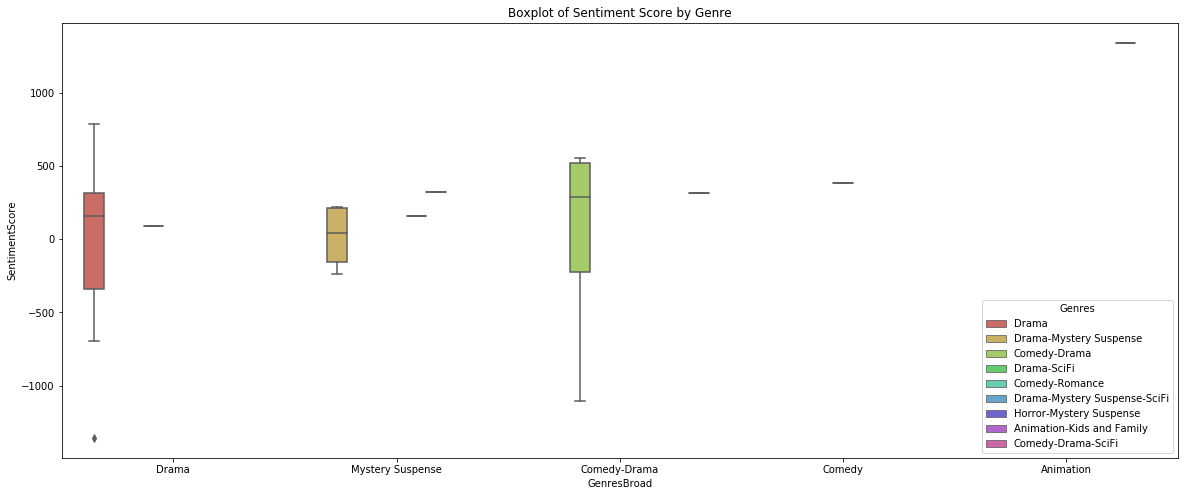

In [55]:
# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='GenresBroad', y="SentimentScore", 
                 hue='Genres', data=afinn_all, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Genre')

Text(0.5, 1.0, 'Bar Plot of Sentiment Score by Genre')

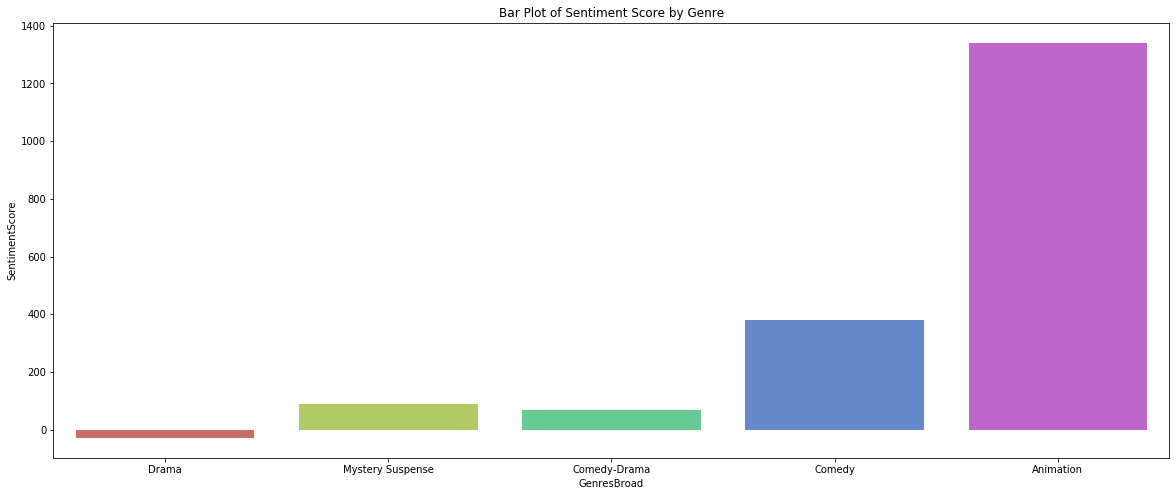

In [56]:
# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "GenresBroad", y = "SentimentScore", ax=ax, data=afinn_all, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Genre')

Text(0.5, 1.0, 'Count Plot of Sentiment Score by GenreBroad')

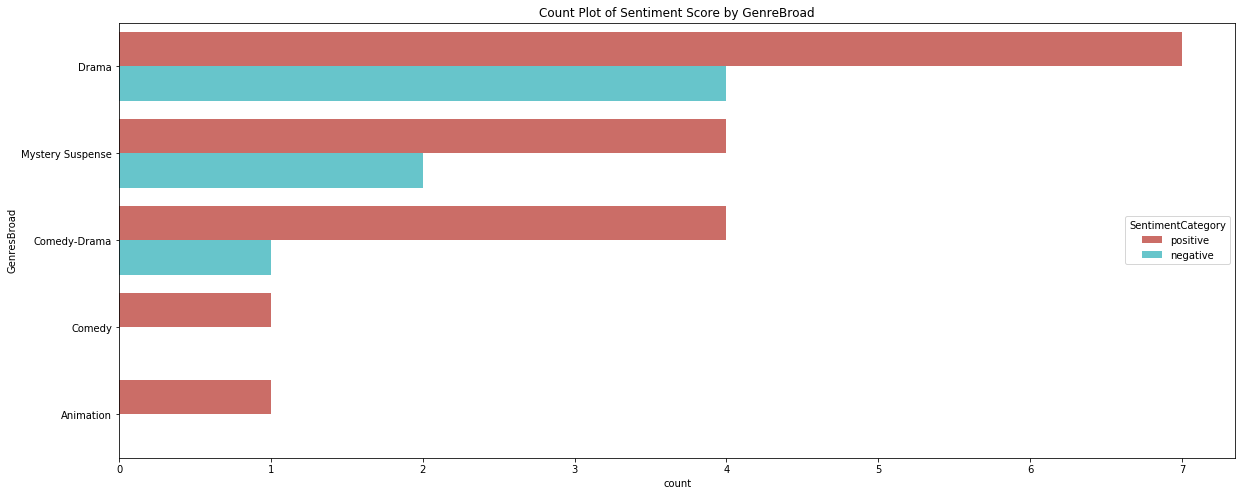

In [57]:
# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="GenresBroad", hue="SentimentCategory", data=afinn_all, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by GenreBroad')

## Topic Modeling -- AS

TFIDF

### Topic Modeling -- Dialogue

### Topic Modeling -- Full Script

## K Means Clustering  -- AR

Either on CV and TFIDF, or just on NMF

https://towardsdatascience.com/k-means-clustering-chardonnay-reviews-using-scikit-learn-nltk-9df3c59527f3

https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a

https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

https://medium.com/@masarudheena/4-best-ways-to-find-optimal-number-of-clusters-for-clustering-with-python-code-706199fa957c

https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92



In [58]:
# # BOW all
# bow_all_fit
# # BOW dialogue
# bow_dialogue_fit
# # TFIDF all
# tfidf_all_fit
# # TFIDF dialogue
# tfidf_dialogue_fit

In [59]:
# NMF - (1,1), (1,2), (2,3)

In [60]:
def eval_k(kmeans, centroids, terms):
    cluster_terms = []
    for i in range(kmeans.n_clusters):
        termss = []
        for ind in centroids[i, :10]:
            termss.append(terms[ind])
        cluster_terms.append(termss)
    for i in range(kmeans.n_clusters):
        print(f'\tCluster {i+1}: {" ".join(cluster_terms[i])}')

### K Means Clustering -- Dialogue

#### CV

In [61]:
# get feature names
bow_dialogue_feat_names = bow_dialogue.get_feature_names()

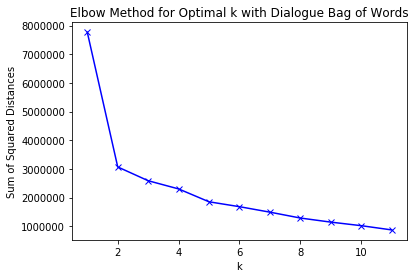

In [62]:
# Elbow Method to determine optimal k in k means clustering
# calculate sum of squared distances
K = range(1,12)
ssd = [KMeans(n_clusters=k).fit(bow_dialogue_fit).inertia_ for k in K]

# plot results
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k with Dialogue Bag of Words')
plt.show()

In [63]:
# K-Means with Count Vectorized
k_bow_dialogue = KMeans(n_clusters = 2, random_state = 0).fit(bow_dialogue_fit)
k_bow_dialogue_centroids = k_bow_dialogue.cluster_centers_.argsort()[:, ::-1]
k_bow_dialogue_terms = bow_dialogue_feat_names
k_bow_dialogue_labels = k_bow_dialogue.labels_

print("Count Vectorized Dialogue:")
eval_k(k_bow_dialogue, k_bow_dialogue_centroids, k_bow_dialogue_terms)

Count Vectorized Dialogue:
	Cluster 1: wa look know like get go back see one right
	Cluster 2: la cleo de el se que en un los seora


#### TFIDF

In [64]:
# get feature names
tfidf_dialogue_feat_names = tfidf_dialogue.get_feature_names()

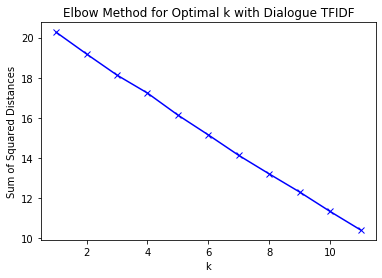

In [65]:
# Elbow Method to determine optimal k in k means clustering
# calculate sum of squared distances
K = range(1,12)
ssd = [KMeans(n_clusters=k).fit(tfidf_dialogue_fit).inertia_ for k in K]

# plot results
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k with Dialogue TFIDF')
plt.show()

In [66]:
# K-Means with Count Vectorized
k_tfidf_dialogue = KMeans(n_clusters = 2, random_state = 0).fit(tfidf_dialogue_fit)
k_tfidf_dialogue_centroids = k_tfidf_dialogue.cluster_centers_.argsort()[:, ::-1]
k_tfidf_dialogue_terms = tfidf_dialogue_feat_names
k_tfidf_dialogue_labels = k_tfidf_dialogue.labels_

print("TFIDF Dialogue:")
eval_k(k_tfidf_dialogue, k_tfidf_dialogue_centroids, k_tfidf_dialogue_terms)

TFIDF Dialogue:
	Cluster 1: wa know kumail like yeah na get cheney right well
	Cluster 2: look im dont wa like get know back go see


#### NMF

### K Means Clustering -- Full Script

#### CV

In [67]:
# get feature names
bow_all_feat_names = bow_all.get_feature_names()

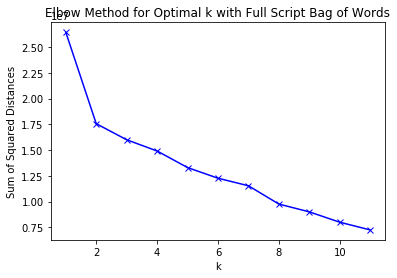

In [68]:
# Elbow Method to determine optimal k in k means clustering
# calculate sum of squared distances
K = range(1,12)
ssd = [KMeans(n_clusters=k).fit(bow_all_fit).inertia_ for k in K]

# plot results
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k with Full Script Bag of Words')
plt.show()

In [69]:
# K-Means with Count Vectorized
k_bow_all = KMeans(n_clusters = 2, random_state = 0).fit(bow_all_fit)
k_bow_all_centroids = k_bow_all.cluster_centers_.argsort()[:, ::-1]
k_bow_all_terms = bow_all_feat_names
k_bow_all_labels = k_bow_all.labels_

print("Count Vectorized Full Script:")
eval_k(k_bow_all, k_bow_all_centroids, k_bow_all_terms)

Count Vectorized Full Script:
	Cluster 1: int look wa get know like back go day see
	Cluster 2: la cleo de el seora sofa se que en pepe


#### TFIDF

In [70]:
# get feature names
tfidf_all_feat_names = tfidf_all.get_feature_names()

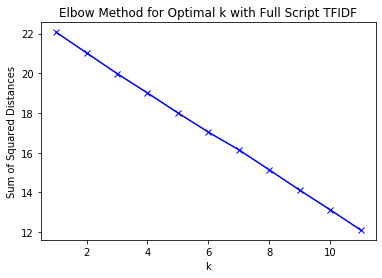

In [71]:
# Elbow Method to determine optimal k in k means clustering
# calculate sum of squared distances
K = range(1,12)
ssd = [KMeans(n_clusters=k).fit(tfidf_all_fit).inertia_ for k in K]

# plot results
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k with Full Script TFIDF')
plt.show()

In [72]:
# K-Means with Count Vectorized
k_tfidf_all = KMeans(n_clusters = 2, random_state = 0).fit(tfidf_all_fit)
k_tfidf_all_centroids = k_tfidf_all.cluster_centers_.argsort()[:, ::-1]
k_tfidf_all_terms = tfidf_all_feat_names
k_tfidf_all_labels = k_tfidf_all.labels_

print("TFIDF Full Script:")
eval_k(k_tfidf_all, k_tfidf_all_centroids, k_tfidf_all_terms)

TFIDF Full Script:
	Cluster 1: dorothea julie jamie lady bird marion abbie kyle danny jenna
	Cluster 2: wa int chris know kumail donovan get lee eazy schofield


#### NMF

In [ ]:
# # qualitatively compare results, see if docs make sense 
# data = {"article": list(cleaned_train), "y": list(newsgroups_train.target), 
#         "kmeans_cv_label": list(k_cv_labels), 
#         "kmeans_tfidf_label": list(k_tfidf_labels), 
#         "kmeans_nmf_label": list(k_nmf_labels), 
#         "agg_cv_label": list(agg_cv_labels), 
#         "agg_tfidf_label": list(agg_tfidf_labels), 
#         "agg_nmf_label": list(agg_nmf_labels)}

# results = pd.DataFrame(data)

# # logic for how to match numeric label to category from Stack Overflow
# # https://stackoverflow.com/a/61241242/10145953
# idxs = [idx for idx, cat in enumerate(newsgroups_train.target_names)]
# cats = [cat for idx, cat in enumerate(newsgroups_train.target_names)]
# def y_to_name(text):
#     for i in idxs:
#         if i == text:
#             cat = cats[i]
#         else:
#             pass
#     return cat
# results['target_names'] = results['y'].apply(lambda x: y_to_name(x))

## Cosine similarity

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn.metrics.pairwise.cosine_similarity

## Additional Visualizations

https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-3-zipfs-law-data-visualisation-fc9eadda71e7

https://towardsdatascience.com/visualizing-topic-models-with-scatterpies-and-t-sne-f21f228f7b02

https://towardsdatascience.com/how-to-use-ggplot2-in-python-74ab8adec129

https://itnext.io/basics-of-text-analysis-visualization-1978de48af47

https://www.kaggle.com/dhanyajothimani/basic-visualization-and-clustering-in-python

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

https://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-clusters-in-a-k-means-unsupervised-learning-model/



## Deprecated Code

Code we attempted to leverage in our project but ended up scrapping, for some reason or another

In [73]:
# # train-test split all
# y_all = movies_df['orig_screen_win']
# X_all = movies_df['cleaned_script']
# X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, 
#                                                                     y_all, 
#                                                                     test_size=0.2, 
#                                                                     random_state=16)

# print(X_train_all.shape)
# print(X_test_all.shape)
# print(y_train_all.shape)
# print(y_test_all.shape)

# # train-test split dialogue
# y_dialogue = movies_df['orig_screen_win']
# X_dialogue = movies_df['cleaned_dialogue']
# X_train_dialogue, X_test_dialogue, y_train_dialogue, y_test_dialogue = train_test_split(X_dialogue, 
#                                                                                         y_dialogue, 
#                                                                                         test_size=0.2, 
#                                                                                         random_state=16)

# print(X_train_dialogue.shape)
# print(X_test_dialogue.shape)
# print(y_train_dialogue.shape)
# print(y_test_dialogue.shape)

In [74]:
# ## AS 

# # Create function to prepare text for additional separation by visual cues and speaking parts
# def add_PoS(text):
#     sentences = [w_tokenize(sent) for sent in text] # tokenize text
#     for i in range(len(sentences)):
#         sentences[i] = [w for w in sentences[i] if w not in punc] # remove punctuation
#     for i in range(len(sentences)):
#         sentences[i] = [w for w in sentences[i] if w not in stop_words] # remove stopwords
#     pos_text = [nltk.pos_tag(speech) for speech in sentences] # assign PoS to words
#     return pos_text

In [75]:
# ## AS + AR
# def clean_from_PoS(pos_dialogue):
#     visuals = []
#     dialogue = []
#     for t in range(len(pos_dialogue)):
#         if len(pos_dialogue[t]) > 2:
#             if pos_dialogue[t][1][1] == 'NN' and pos_dialogue[t][2][1] == 'VBZ' or pos_dialogue[t][2][1] == 'VBG':
#                 visuals.append(pos_dialogue[t])
#             elif (pos_dialogue[t][0][1] == 'VBN' or pos_dialogue[t][0][1] == 'VBG'):
#                 visuals.append(pos_dialogue[t])
#             elif (pos_dialogue[t][0][1] == 'PRP' or pos_dialogue[t][0][1] == 'NNP') and \
#                 (pos_dialogue[t][1][1] == 'VBP' or pos_dialogue[t][1][1] == 'NN' or pos_dialogue[t][1][1] == 'VBZ' or\
#                  pos_dialogue[t][1][1] == 'NNS' or pos_dialogue[t][1][1] == 'VBG' or pos_dialogue[t][1][1] == 'VBD'):
#                 visuals.append(pos_dialogue[t])
#             elif (pos_dialogue[t][0][1] == 'IN' or pos_dialogue[t][0][1] == 'DT') and (pos_dialogue[t][1][1] == 'NNP' or\
#                  pos_dialogue[t][1][1] == 'JJ' or pos_dialogue[t][1][1] == 'NN' or pos_dialogue[t][1][1] == 'RB' or\
#                 pos_dialogue[t][1][1] == 'VBZ' or pos_dialogue[t][1][1] == 'VBG' or pos_dialogue[t][1][1] == 'CD'):
#                 visuals.append(pos_dialogue[t])
#             elif (pos_dialogue[t][0][1] == 'IN' or pos_dialogue[t][0][1] == 'DT')  and pos_dialogue[t][1][1] == 'NNP' and\
#                 pos_dialogue[t][2][1] == 'VBZ':
#                 visuals.append(pos_dialogue[t])
#             else:
#                 dialogue.append(pos_dialogue[t])
#     just_dialogue = [d[0][0] for d in dialogue]
#     return just_dialogue

In [76]:
# # Create functions to better separate visual cues vs. dialogue using PoS

# ## Need Help on this One for iterating over all; Each section is functioning and useable; Just need to figure out
# # how to define it as one whole function if possible.

# # How do I iterate through all titles to use the rules that I have set up per each script?

# def double_clean(test, titles):
#     vis = []
#     dialogue = []
# #     for s in range(len(titles)):
# #         title = titles[s]
# #         Skip = [4, 6, 7, 10, 11, 13, 15, 16, 19, 20]
# #         if s in Skip:
# #             continue
            
#                 for t in (range(len(test))):
#                     if len(test[t]) > 1:

#                         if test[t][0][0].isupper() and test[t][0][1] == 'NNP':
#                             dialogue.append(test[t])

#                         elif test[t][0][1] == 'NNP' and test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG':
#                              vis.append(test[t])

        
#                         elif test[t][0][0].isupper() and test[t][0][1] == 'NNP': # script 5
#                             dialogue.append(test[t])

#                         elif test[t][1][1] == 'NNP' and test[t][2][1] == 'VBZ' or \
#                             test[t][2][1] == 'VBG' or test[t][2][1] == 'VBD':
#                             vis.append(test[t])

#                         elif test[t][0][0] == 'SERGEANT' and test[t][1][1] != 'NNP':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNP' and test[t][1][1] == 'NN' or test[t][1][1] == 'NNS':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNP' and test[t][1][1] == 'RB' or test[t][1][1] == 'NNS':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNP' and test[t][1][1] == 'NN' and test[t][2][1] != 'VBG':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNP' and test[t][1][1] == 'VBZ' or test[t][1][1] == 'VBG' or test[t][1][1] == 'VBD':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'DT' and test[t][1][1] == 'JJ' or test[t][1][1] == 'NN' or test[t][1][1] == 'NNP':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'PRP' and (test[t][1][1] == 'VBP' or \
#                             test[t][1][1] == 'VBZ'):
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'IN' and (test[t][1][1] == 'JJ' or test[t][1][1] == 'RB'):
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'RB' and test[t][1][1] == 'RB' or test[t][1][1] == 'JJ':
#                             vis.append(test[t])

#                         else:
#                             dialogue.append(test[t])

#             if s == 1:
#                 for t in (range(len(test))):
#                     if len(test[t]) > 1:
#                         if test[t][1][1] == 'NN' and test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG':
#                             vis.append(test[t])

#                         elif test[t][0][0].isupper() and test[t][0][1] == 'NNP' and  test[t][1][0].istitle() == False:
#                             vis.append(test[t])

#                         elif test[t][0][1].istitle() and test[t][0][1] == 'NNP' and test[t][1][1] == 'NNS':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'NNP' and test[t][1][1] == 'VBD':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'NNP' and test[t][1][1] == 'VBZ':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'NNP' and test[t][1][1] == 'NNS':
#                             vis.append(test[t])

#                         elif test[t][-1][0].isupper() and test[t][-1][1] == 'NNP':
#                             vis.append(test[t])

#                         elif test[t][0][0] == r'MOMENTS' and  test[t][1][0] == r'LATER':
#                             vis.append(test[t])

#                         elif test[t][0][0] == r'LATER':
#                             vis.append(test[t])

#                         elif test[t][0][0] == r'VISUALS':
#                             vis.append(test[t]) 

#                         elif test[t][0][0].isupper() and test[t][0][1] == 'RB' and  test[t][1][0].isupper() == True:
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'RB' and  test[t][1][1] == 'IN' and \
#                             test[t][2][1] == 'PRP$':
#                             vis.append(test[t])


#                         elif test[t][0][0].istitle() and test[t][0][1] == 'NNP' and test[t][1][1] == 'VBZ' and \
#                             test[t][2][1] != 'VBN' and test[t][3][1] != 'TO':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'PRP' and test[t][1][1] == 'VBD' and \
#                             test[t][1][1] == 'VBP' and test[t][2][1] != 'NNS' and  test[t][2][1] != 'RP' and \
#                             test[t][2][1] != 'DT' and test[t][3][1] != 'VB':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'PRP' and test[t][1][1] == 'VBP' and \
#                             test[t][2][1] == 'VBG':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'PRP' and test[t][1][1] == 'DT' and \
#                             test[t][2][1] == 'VBP':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'PRP' and test[t][1][1] == 'VBP' \
#                             and test[t][2][1] == 'TO':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and (test[t][0][0] == r'She' or test[t][0][0] == r'He') and \
#                             test[t][0][1] == 'PRP' and (test[t][1][1] == 'VBZ' or test[t][1][1] == 'VBD'):
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and (test[t][0][0] == r'She' or test[t][0][0] == r'He') and \
#                             test[t][0][1] == 'PRP' and (test[t][1][1] == 'VBZ' or test[t][1][1] == 'VBD') and \
#                             test[t][2][1] == 'PDT':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][0] == r'Dorothea' and test[t][0][1] == 'NNP' and \
#                             test[t][1][1] == ('NNS'):
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and (test[t][0][0] == r'Dorothea' or test[t][0][0] == r'Julie') and \
#                             test[t][0][1] == 'NNP' and test[t][1][1] == ('VBZ'):
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'NN' and test[t][1][1] == 'VBZ' and \
#                             test[t][2][1] != 'JJ':
#                             vis.append(test[t])

#                         elif test[t][0][0].isupper() and test[t][0][1] == 'NN' and test[t][1][1] != ('PRP'):
#                             vis.append(test[t])


#                         elif test[t][0][0].istitle() and test[t][0][1] == 'DT' and test[t][1][1] == ('NN') and \
#                             test[t][2][1] == ('VBZ'):
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'JJ' and test[t][1][1] == ('NN') and \
#                             test[t][2][1] != 'PRP':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'JJ' and test[2][1] != 'PRP' :
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'PRP' and test[t][1][1] == 'VBZ':
#                             vis.append(test[t])

#                         elif test[t][0][0].istitle() and test[t][0][1] == 'NNP' and test[t][1][1] == 'VBZ':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'DT' and test[t][1][1] == 'NN' and test[t][2][1] == 'VBG':
#                             vis.append(test[t])

#                         elif test[t][0][0].isupper() and test[t][0][1] == 'NN' and test[t][1][0].isupper() \
#                             and test[t][1][1] != 'NNP':
#                             vis.append(test[t])

#                         elif test[t][0][0].isupper() and test[t][0][1] == 'NNP' and test[t][1][0].isupper() \
#                             and test[t][1][1] != 'NNP':
#                             vis.append(test[t])

#                         elif test[t][0][0].isupper() and test[t][1][0] == r'CONTD' and test[t][1][1] != 'NNP':
#                             vis.append(test[t])
                
#                 # Script 2
        
#                         if test[t][1][1] == 'NN' and test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG':
#                             vis.append(test[t])
            
#                         elif  test[t][0][0] == 'INSIDE' or test[t][0][0] == 'DISSOLVE' or test[t][0][0] == 'TITLE' or \
#                             test[t][0][0] == 'NEW' or test[t][0][0] == 'HALLWAY' or test[t][0][0] == 'RECEPTION':
#                             vis.append(test[t])

#                         elif test[t][0][1].isupper() and test[t][1][1] == 'VBZ': #or test[t][2][1] == 'VBG':
#                              vis.append(test[t])

#                         elif  test[t][0][0].isupper() and test[t][1][0].isupper() and test[t][2][1] == 'DT':
#                             vis.append(test[t])

#                         elif  test[t][0][0].isupper() and test[t][1][0].isupper():
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'DT' and test[t][1][1] == 'JJ':
#                             vis.append(test[t]) 
                
#                 # Script 3
#                         if test[t][1][1] == 'NN' and test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG':
#                              vis.append(test[t])

#                         elif  test[t][0][1] == 'WRB':
#                             dialogue.append(test[t])

#                         elif  test[t][0][1] == 'WP':
#                             dialogue.append(test[t])

#                         elif  test[t][0][1] == 'IN' or test[t][0][1] == 'RB':
#                             vis.append(test[t])

#                         elif  test[t][0][1] == 'IN' and test[t][1][1] == 'NNP':
#                             vis.append(test[t])

#                         elif  test[t][0][1] == 'NNP' and test[t][1][1] == 'NNP':
#                             dialogue.append(test[t])

#                         elif test[t][0][1] == 'PRP' and test[t][1][0].startswith('I') and \
#                             test[t][1][1] == 'VBD':
#                             dialogue.append(test[t])

#                         elif  test[t][0][0].isupper() and  test[t][0][1] == 'NNP':
#                             vis.append(test[t])

#                         elif  test[t][0][0].startswith('Moments'):
#                             vis.append(test[t])

#                         elif  test[t][0][0].startswith('CALEB') and test[t][1][1] == 'NNS':
#                             vis.append(test[t])


#                         elif  test[t][0][1] == 'VBG' or test[t][0][1] == 'VBN':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'PRP' and test[t][1][1] == 'VBD' and test[t][2][1] == 'NNS':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'PRP' and test[t][1][0].startswith('I') and \
#                             test[t][1][1] == 'VBD' or test[t][1][1] == 'VBP':
#                             dialogue.append(test[t])

#                         elif test[t][0][1] == 'PRP' and test[t][1][1] == 'VBD' or test[t][1][1] == 'VBZ' or test[t][1][1] == 'VBP':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'PRP' and test[t][1][1] == 'RB':
#                             vis.append(test[t])

#                         elif  test[t][0][1] == 'DT' and test[t][1][1] == 'NNP':
#                             vis.append(test[t])

#                         elif  test[t][0][1] == 'NNS' and test[t][1][1] == 'JJ':
#                             vis.append(test[t])

#                         elif  test[t][0][1] == 'TO' and test[t][1][1] == 'VB':
#                             vis.append(test[t])

#                         elif  test[t][0][1] == 'EX' and test[t][1][1] == 'JJ':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'DT' and test[t][1][1] == 'JJ':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'CD':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'CC' and test[t][1][1] == 'NNS':
#                             vis.append(test[t])


            
            
#              # Script # 5        
#                         if test[t][1][1] == 'NN' and (test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG'):
#                                  vis.append(test[t])

#                         elif test[t][0][1] == 'IN' and test[t][1][1] == 'NNP':
#                             vis.append(test[t])


#                         elif test[t][0][1] == 'PRP' and test[t][1][1] == 'VBP':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNP' and test[t][1][1] == 'VBZ':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNP' and test[t][1][1] == 'WP':
#                             dialogue.append(test[t])

#                         elif test[t][0][0] == 'TUTORIAL' or test[t][0][0] == 'TITLE':
#                             vis.append(test[t])

#                         elif test[t][0][0].isupper() and test[t][1][1] == 'NNP':
#                             dialogue.append(test[t])

#                         elif test[t][0][1] == 'EX' and test[t][1][1] == 'JJ':
#                             vis.append(test[t])
                        
#                         else:
#                             dialogue.append(test[t])
            


#             # Script # 8
#                         if test[t][1][1] == 'NN' and (test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG'):
#                              vis.append(test[t])

#                         elif test[t][0][1] == 'NN' and (test[t][1][1] == 'VBZ' or test[t][1][1] == 'VBG'):
#                              vis.append(test[t])

#                         elif test[t][0][0] == 'LATER' or test[t][0][0] == 'ON' or test[t][0][0] == 'FLASH' or \
#                             test[t][0][0] == 'INSERT' or test[t][0][0] == 'POP' or test[t][0][0] == 'POOF' or \
#                             test[t][0][0] == 'BOOM' or test[t][0][0] == 'QUICK':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'IN' and (test[t][1][1] == 'JJ' or test[t][1][1] == 'RB'):
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'DT' and (test[t][1][1] == 'NNS' or test[t][1][1] == 'JJ' or 
#                                                         test[t][1][1] == 'NN' or test[t][1][1] == 'NNP'):
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNP' and test[t][1][1] == 'VBZ' and test[t][2][1] == 'NN':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNP' and (test[t][1][1] == 'VBZ' or test[t][1][1] == 'NNS' or test[t][1][1] == 'NN'):
#                             vis.append(test[t])  

#                         elif  test[t][0][1] == 'DT' and test[t][1][0].isupper() and (test[t][1][1] == 'JJ' or test[t][1][1] == 'NN' or
#                                                                                     test[t][1][1] == 'NNP'):
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'PRP' and (test[t][1][1] == 'VBZ' or test[t][1][1] == 'VBP' or test[t][1][1] == 'VBD'):
#                             vis.append(test[t])

#                         else:
#                             dialogue.append(test[t])
            
#                   # Script # 9          
#                         if test[t][0][1] == 'UH':
#                             dialogue.append(test[t])

#                         elif test[t][0][0] == 'CUT' or test[t][0][0] == 'Cut' or test[t][0][0] == 'MINUTES':
#                             vis.append(test[t])

#                         elif test[t][0][0].isupper() and (test[t][0][1] == 'NNP' or test[t][0][1] == 'NN'):
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'VBG':
#                             vis.append(test[t])

#                         elif (test[t][0][1] == 'NNP' or test[t][0][1] == 'PRP' or test[t][0][1] == 'DT' or test[t][0][1] == 'JJ') and \
#                             (test[t][1][1] == 'NN' or test[t][1][1] == 'NNS' or test[t][1][1] == 'NNS' or \
#                             test[t][1][1] == 'RB' or test[t][1][1] == 'VBG' or\
#                             test[t][1][1] == 'VBZ'):
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'CC' and (test[t][1][1] != 'VBG'):
#                             vis.append(test[t])

#                         elif test[t][1][1] == 'NN' and (test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG'):
#                              vis.append(test[t])

#                         elif test[t][0][1] == 'IN' and (test[t][1][1] == 'JJ' or test[t][1][1] == 'VBN'):
#                             vis.append(test[t])


#                         else:
#                             dialogue.append(test[t])

#         # Script # 12  
#                         if test[t][1][1] == 'NN' and test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG':
#                              vis.append(test[t])

#                         elif (test[t][0][1] == 'NNP' or test[t][0][1] == 'PRP') and (test[t][1][1] == 'VBZ' or test[t][1][1] == 'NNS'):
#                             vis.append(test[t])

#                         elif test[t][0][0] == r'LATER' or test[t][0][0] == r'IN' or test[t][0][0] == r'AT':
#                             vis.append(test[t])

#                         elif test[t][1][0].isupper():
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'DT' and  test[t][1][1] == 'NN' and (test[t][2][1] == 'NNPS' or test[t][2][1] == 'VB'):
#                             dialogue.append(test[t])

#                         elif test[t][0][1] == 'DT' and (test[t][1][1] == 'JJ' or test[t][1][1] == 'NN' or\
#                                                         test[t][1][0] == 'BARTENDER' or test[t][1][1] == 'NNS'):
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'IN' and (test[t][1][1] == 'JJ' or test[t][1][1] == 'RB' or test[t][1][1] == 'NN'):
#                             vis.append(test[t])


#                         else:
#                             dialogue.append(test[t])

            
#         # Script 14 - Parasite
#                          if test[t][1][1] == 'NN' and (test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG'):
#                              vis.append(test[t])

#                         elif test[t][0][0] == 'SLOW' or test[t][2][0] == 'MUSIC' or test[t][0][0] == 'CAMERA' or \
#                             test[t][0][0] == 'Moments' or test[t][0][0] == 'REVEAL':
#                             vis.append(test[t]) 

#                         elif (test[t][0][1] == 'PRP' or test[t][0][1] == 'NN' or test[t][0][1] == 'NNP') and\
#                             (test[t][1][1] == 'VBZ' or test[t][1][1] == 'VBP' or test[t][1][1] == 'VBG' or \
#                             test[t][1][1] == 'NNS') or test[t][2][1] == 'VBZ':
#                              vis.append(test[t])

#                         elif (test[t][0][1] == 'IN' or test[t][0][1] == 'DT' or \
#                               test[t][0][1] == 'PRP' or test[t][0][1] == 'RB') and test[t][1][0].isupper():
#                             vis.append(test[t])

#                         elif (test[t][0][1] == 'IN' or test[t][0][1] == 'DT') and (test[t][1][1] == 'JJ' or test[t][1][1] == 'RB' or \
#                             test[t][1][1] == 'NN' or test[t][1][1] == 'NNS'):
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNP' and (test[t][1][1] == 'NN' or test[t][1][1] == 'NNS' or \
#                                                          test[t][1][1] == 'RB' or test[t][1][1] == 'VBD'):
#                              vis.append(test[t])

#                         elif test[t][0][1] == 'VBG' and (test[t][1][1] == 'NN' or test[t][1][1] == 'NNP' or \
#                                                          test[t][1][1] == 'NNS'):
#                              vis.append(test[t])

#                         elif test[t][0][1] == 'RB' and (test[t][1][1] == 'VBG' or test[t][1][1] == 'NNP'):
#                              vis.append(test[t])

#                         else:
#                             dialogue.append(test[t])
            

#         # Script 17 - Spotlight - Really mixed together
   
#                         if test[t][1][1] == 'NN' and (test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG'):
#                              vis.append(test[t])

#                         elif  test[t][0][0] == 'FADE' or test[t][0][0] == 'INT':
#                             vis.append(test[t])

#                         elif test[t][0][1] == 'NNS' and test[t][1][1] == 'IN':
#                              vis.append(test[t])
        

#                         else:
#                             dialogue.append(test[t])
            
#             # Script #18 - Straight Outta            
#                          if test[t][1][1] == 'NN' and test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG':
#                              vis.append(test[t])

#                         elif (test[t][0][1] == 'VBN' or test[t][0][1] == 'VBG'):
#                             vis.append(test[t])

#                         elif test[t][0][0] == 'Eazy' or test[t][0][0] == 'Suddenly' or \
#                             test[t][0][0] == 'FOLLOW' or test[t][0][0] == 'Cut':
#                             vis.append(test[t])


#                         elif (test[t][0][1] == 'PRP' or test[t][0][1] == 'NNP') and \
#                             (test[t][1][1] == 'VBP' or test[t][1][1] == 'NN' or test[t][1][1] == 'VBZ' or\
#                              test[t][1][1] == 'NNS' or test[t][1][1] == 'VBG' or test[t][1][1] == 'VBD'):
#                             vis.append(test[t])

#                         elif (test[t][0][1] == 'IN' or test[t][0][1] == 'DT') and (test[t][1][1] == 'NNP' or\
#                              test[t][1][1] == 'JJ' or test[t][1][1] == 'NN' or test[t][1][1] == 'RB' or\
#                             test[t][1][1] == 'VBZ' or test[t][1][1] == 'VBG' or test[t][1][1] == 'CD'):
#                             vis.append(test[t])


#                         elif (test[t][0][1] == 'IN' or test[t][0][1] == 'DT')  and test[t][1][1] == 'NNP' and\
#                             test[t][2][1] == 'VBZ':
#                             vis.append(test[t])

#                         else:
#                             dialogue.append(test[t])
      
    
#                         # SCript 21
#                         if test[t][1][1] == 'NN' and test[t][2][1] == 'VBZ' or test[t][2][1] == 'VBG':
#                                  vis.append(test[t])

#                             elif (test[t][0][1] == 'VBN' or test[t][0][1] == 'VBG'):
#                                 vis.append(test[t])


#                             elif (test[t][0][1] == 'PRP' or test[t][0][1] == 'NNP') and \
#                                 (test[t][1][1] == 'NN' or test[t][1][1] == 'VBZ' or\
#                                  test[t][1][1] == 'NNS' or test[t][1][1] == 'VBG' or test[t][1][1] == 'VBD'):
#                                 vis.append(test[t])

#                             elif (test[t][0][1] == 'IN' or test[t][0][1] == 'DT') and (test[t][1][1] == 'NNP' or\
#                                  test[t][1][1] == 'JJ'  or test[t][1][1] == 'RB' or\
#                                 test[t][1][1] == 'VBZ' or test[t][1][1] == 'VBG' or test[t][1][1] == 'CD'):
#                                 vis.append(test[t])


#                             elif (test[t][0][1] == 'IN' or test[t][0][1] == 'DT')  and test[t][1][1] == 'NNP' and\
#                                 test[t][2][1] == 'VBZ':
#                                 vis.append(test[t])

#                             else:
#                                 dialogue.append(test[t])



#     return vis
                        

In [77]:
## OLD CLEANER --- OBSOLETE FUNCTIONS



# titles = list(ACS['Title'])
# def multi_clean(text, titles):
#     for title in titles:
#         if titles[0]:
#             text = re.sub('\n\n\\x0c\s+\d+\.','', text)
#             text = re.sub('^\s+','',text)
#             text = re.sub('\s+\d\.', '', text)
#             text = re.sub('\d\.', '', text)
#             text = re.sub('\n\s\d+\.\n', ' ', text)
#             text = re.sub("\(CONTINUED:\)|\(CONTINUED\)|CONTINUED:|COUNTINUOUS| CONTINUOUS|CONT'D|\(CONT'D\)", ' ', text)
#             text = re.sub('\s+\d', '', text)
#             text = re.sub('\(\d+\)', '', text)
#             text = re.sub('\d', '', text)
#             text = re.sub(' +', ' ', text)
#             text = re.sub('\(MORE\)', '', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)|\(O\.C\.\)| V.O.', '', text)
#             text = re.sub("\(CONT’D\)|\(CONT'D\)|\(CONT'D\)|\s\(CONT'D\)\s+| (CONT’D)",'',text)
#             text = re.sub('\n\n\\x0c\s+\d+\.','', text)
#             text = re.sub('\\x0c','',text)
#         elif titles[1]:
#             text = re.sub("\(CONT’D\)|\(CONT'D\)|\(CONT'D\)|\s\(CONT'D\)\s+| (CONT’D)",'',text)
#             text = re.sub('\n\n\\x0c\s+\d+\.','', text)
#             text = re.sub('\\x0c','',text)
#             text = re.sub('\n*\s+\\n+\d+\.', ' ', text)
#             text = re.sub('\d+\.', '',text)
#             text = re.sub(' +', ' ', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)|O\.S\.|V\.O\.|\sV\.O\.', '', text)
#             text = re.sub('[-/\]', '', text)
#         elif titles[2]:
#             text = re.sub(r'14 FINAL SHOOTING SCRIPT  |\n 12.17.14 FINAL SHOOTING SCRIPT \d+\.|\n 12.17.14 FINAL SHOOTING SCRIPT |\n+ \d+ FINAL SHOOTING SCRIPT  \n+', '', text)
#             text = re.sub("\(CONTINUED:\)|\s\(CONT’D\)\n| \(CONT’D\) \n|\(CONTINUED\)|CONTINUED:|COUNTINUOUS| CONTINUOUS|CONT'D|\(CONT'D\)| \(CONT'D\)|\(CONT..\d\;D\)", ' ', text)
#             text = re.sub('\nPage \d+\/124', '', text)
#             text = re.sub('\n\/Page', '', text)
#             text = re.sub('\\x0c|\\x0c ', '', text)
#             text = re.sub('\d+\.', '',text)
#             text = re.sub('TITLES:', '', text)
#             text = re.sub(' +', ' ', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)', '', text)
#         elif titles[3]:
#             text = re.sub('\d+\n+\d+\w\n+\d|\n+\d+', '', text)
#             text = re.sub('\n+\\x0c\d+','', text)
#             text = re.sub("\(CONT’D\)| \(CONT'D\)",'', text)
#             text = re.sub(' +', ' ', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)', '', text)
#         elif titles[4]:
#             text = re.sub('\nPage \d+\/94', '', text)
#             text = re.sub('\\x0c', '', text)
#             text = re.sub('\n\d+\.', '', text)
#             text = re.sub(' +', ' ', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)', '', text)
#         elif titles[5]:
#             text = re.sub("\(CONT’D\)| \(CONT'D\)",'', text)
#             text = re.sub('\\x0c', ' ', text)
#             text = re.sub('\n\d+\.', ' ', text)
#             text = re.sub(' +', ' ', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)', '', text)
#         elif titles[6]:
#             text = re.sub('^\s', '', text)
#             text = re.sub('\\x0c', ' ', text)
#             text = re.sub('\n\d+\.|\n \d+\.', ' ', text)
#             text = re.sub('\(MORE\)', '', text)
#             text = re.sub(' +', ' ', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)', '', text)
#         elif titles[7]:
#             text  = re.sub('\n\*\n', '', text)
#             text = re.sub('\\x0c', ' ', text)
#             text = re.sub('\n +', ' ', text)
#             text = re.sub("\(CONT’D\)| \(CONT'D\)| \(CONT\\'D\)",'', text)
#             text = re.sub('\n\d+\.|\n \d+\.', ' ', text)
#             text = re.sub(' +', ' ', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)', '', text)
#         elif titles[8]:
#             text = re.sub('^\s', '', text)
#             text = re.sub('\\x0c\d\.', ' ', text)
#             text = re.sub('\\x0c', ' ', text)
#             text = re.sub("\(CONT’D\)| \(CONT'D\)| \(CONT\\'D\)",'', text)
#             text = re.sub('\n\d+|\n\d+\.| \d+\n| \d+\.', '', text)
#             text = re.sub(' +', ' ', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)', '', text)
#         elif titles[9]:
#             text = re.sub('\nPage \d+\/152', '', text)
#             text = re.sub('\\x0c', ' ', text)
#             text = re.sub('\n11/26/14', '', text)
#             text = re.sub('\d+\.|\d+', '', text)
#             text = re.sub("\(CONT\’D\)| \(CONT\'D\)| \(CONT\'D\)\s+| \(CONT\\'D\)",' ', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)|\(O\.C\.\)', '', text)
#         elif titles[10]:
#             text = re.sub('^\n\(\)- ', '', text)
#             text = re.sub('^\n\(d+\)d+\-d+ ', '', text)
#             text = re.sub('\\x0c', ' ', text)
#             text = re.sub('\n\d\.| \d\.|\n \d+\.|\n\d+\.', '', text)
#             text = re.sub("\(CONT’D\)| \(CONT'D\)| \(CONT\\'D\)",' ', text)
#             text = re.sub('\(MORE\)', '', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)', '', text)
#         elif titles[11]:
#             text = re.sub('\\x0c', ' ', text)
#             text = re.sub('^\s+', '', text)
#             text = re.sub('^Films\n+ \d\n\n', '', text)
#             text = re.sub("\(CONT’D\)| \(CONT'D\)| \(CONT\\'D\)",' ', text)
#             text = re.sub('\n\d\.| \d\.|\n \d+\.|\n\d+\.| \d\n|\n\d|\n\d |\n\d\n', '', text)
#             text = re.sub('\(V\.O\.\)|\(O\.S\.\)', '', text)
#         text = expand_contractions(text)
#         return text
    

# ## Attempts at LookArounds
    
# def speaking_parts(text):
#     speaking = []
#     visual = []
#     # split on combo of caps and new lines
#     #text = re.split("\\n[A-Z]*\s?\\n", text)
#     #for line in text:
#         #if line.isupper() == True:
#     pattern = re.compile('[A-Z]+.+[A-Z] \n\n(\w.+\.)(?= \n\n)')
#     pattern2 = re.compile('[A-Z]+.+[A-Z]()(?= \n\n)')
#     pattern3 = re.compile('(?<=\n\nVISUALS\s)([A-Z]+.+)(?=\n\n)')
#     pattern4 = re.compile('(?<=\n\nVISUALS\s)([A-Z]+.+)(?=\n)')
#     pattern5 = re.compile('(?<=\n\nVISUALS\s)([A-Z]+.+)(?=\n)')
#     pattern6 = re.compile('(?<=\n\n[A-Z] \n\n)(\w+.+\n+\w.+)(?=\.|\?|\!)')
#     pattern7 = re.compile('(?<=\n\n\DOROTHEA\s\n\n)\w.*\w+')
#     text = re.sub(' \n', ' ', text)
#     text = re.sub('\n', '', text)
#     text = re.sub('[)/\-;(] ','', text)
#     # gets all capital words
#     vis = re.findall(pattern7, text)
    
#     #pattern_a = re.compile('(?<=\n\n[A-Z] \n)(\w.+\w.)')
#     #vis2 = re.findall()
    

#     return text



# # Manual Cleaning

# #def Manual_Clean(text):
# visuals = []
# for t in range(len(test)):
#     if t == 3:
#         vis = test[1:5]
#         visuals.append(vis)
#     if t == 5:
        
#         vis = test[0]
#         visuals.append(vis)
        

# print (visuals)
            